In [1]:
#!pip install kramersmoyal
import pandas as pd
import numpy as np
from kramersmoyal import km

import os
import pickle
   

from utils.Data_cleaning import data_cleaning
from utils.Functions import data_filter, integrate_omega, KM_Coeff_1, KM_Coeff_2, daily_profile, power_mismatch, exp_decay, Euler_Maruyama, Increments, autocor 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.optimizers import SR3
from scipy.ndimage import gaussian_filter1d
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

#### Choose the grid: (Balearic, Irish or Iceland)

In [3]:
#grids = ['IS02','IRL01','ES_PM01']  
#grids = ['Balearic','Irish','Iceland' ]  
#grids = ['Iceland']  
#grids = ['Irish']
grids = ['Balearic']

In [4]:
dict_grids = {'Balearic':'ES_PM01','Irish':'IRL01','Iceland':'IS02'}
#dict_freq_grids = {'Balearic':'f50_ES_PM','Irish':'f50_IRL01'}
dict_freq_grids = {'Balearic':'f50_ES_PM','Irish':'f50_IRL01','Iceland':'f50_IS' }

In [5]:
models = ['model 1','model 2','model 3','model 4']

#freq_orig = data/(2*np.pi+50)
#increments_orig = Increments(data/(2*np.pi+50))

'''For calculations: use angular velocity omega = 2*pi*frequency '''
'''The bandwidth is chosen such that we receive a scmooth distribution'''

'''Choose the grid '''

'''Data analysis of the original time series'''
data_orig          = {i:[]for i in grids}



edges_1d     = {i:[]for i in grids}
drift_1d     = {i:[]for i in grids}
diffusion_1d = {i:[]for i in grids}
edges_2d     = {i:[]for i in grids}
kmc_2d       = {i:[]for i in grids}

for grid in grids:
    time_res = 1
    '''Choose the grid '''
    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')  
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    #print(freq)


    data_orig[grid].append(freq)
   

Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


The empirical data is given by data_orig[grid] (grid = Irish, Iceland, Balearic.)
In the following the different models are calculated, i.e. the synthetic time series is given by "omega_synth_model_i" (i=1,2,3,4).
\
The default length of the calculated synthetic time series is 5 days (t_final=5).
\
The time step delta_t should be chosen smaller or equal than one. Here we use delta_t = 0.1.

In [6]:
def extract_data (data_set, n=900):
    """
    Extract  'omega' and 'theta' from the given dataset.
    """
    # Check if the dataset is not empty
    if data_set:
        omega = data_set[0][0]
        theta = data_set[0][1]

        
        omega_extract = omega[:n]
        theta_extract = theta[:n]

        return omega_extract, theta_extract

In [7]:
def integrate_data(data, dt=1):
    """
    Manually integrate the data using a simple Euler integration method.

    Parameters:
    data (array): The input data to be integrated.
    dt (float): The time step for integration.

    Returns:
    integrated_data: The integrated data.
    """
    
    integrated_data = np.zeros(len(data))
    for i in range(1, len(data)):
        integrated_data[i] = integrated_data[i-1] + data[i] * dt
    return integrated_data

### Model 2 case A, B, and C

In [8]:
'''Model 2...'''
np.random.seed(12345678)
noise_data_model_2 = {i:[]for i in grids}
ideal_data_model_2 = {i:[]for i in grids}
time_data_model_2 = {i:[]for i in grids}
c_1_model2 = {i:[]for i in grids}
c_2_model2 = {i:[]for i in grids}
epsilon_model2 = {i:[]for i in grids}

'''adapt the parameter estimation to the particulat grids'''
for grid in grids:

    #raw=pd.read_csv('./Data/Frequency_data_%s.csv'%(grid), sep=',')
    #freq = (raw[['Frequency']]/1000 +50).squeeze()
    #freq = data_cleaning(freq)
    
    raw=pd.read_csv('Data/%s.csv'%(dict_grids[grid]), sep=';')  
    freq = (raw[[dict_freq_grids[grid]]]/1000 +50).squeeze()
    freq = data_cleaning(freq)
    
    data = (freq-50)*(2*np.pi)   #Use the angular velocity for the calcualltions

    trend = 1 #trend is boolean
    bw_drift = 0.1
    bw_diff = 0.1
    dist_drift = 500    #for large data set: dist_drift = 350 for Balearic
    dist_diff = 500
    if grid == 'Balearic':
        Delta_P = power_mismatch(data,avg_for_each_hour = False,dispatch=2,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)
        dispatch = 1
    elif grid == 'Irish':
        Delta_P = power_mismatch(data_filter(data,sigma = 6),avg_for_each_hour = False,dispatch=1,start_minute=0,end_minute=1/6,length_seconds_of_interval=5)
        dispatch = 2
        #we use a filter for the power mismatch of the Iroish data because of regular outliers (every 60 seconds)
    elif grid == 'Iceland':
        Delta_P = 0
        dispatch = 0
        trend = 0 # Represents a no-existing trend as there is no power dispatch schedule
        
    c_1 = KM_Coeff_1(data - trend*data_filter(data),dim= 1,time_res = 1,bandwidth = bw_drift,dist = dist_drift, order = 1)
    c_2_decay = trend*exp_decay(data,time_res=1,size = 899)
    epsilon =   epsilon = KM_Coeff_2(data - trend*data_filter(data),dim = 1,time_res = 1,bandwidth = bw_diff,dist = dist_diff,multiplicative_noise = False)
    #epsilon = 0

    kmc,edges = km(data - trend * data_filter(data),powers = [0,1,2],bins = np.array([6000]),bw=bw_drift)
    edges_1d[grid] = edges[0]
    drift_1d[grid] = kmc[1]
    diffusion_1d[grid] = kmc[2] 
    c_1_model2[grid] = c_1
    c_2_model2[grid] = c_2_decay * c_1
    epsilon_model2[grid] = epsilon

    delta_t = 1 #time step for Euler-Maruyama
    
    # with noise there are 96 intervals of 15 minutes each in one day.
    omega_noise_model_2, theta_noise_model_2, p1 = Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*96*30,model=2,factor_daily_profile=0,sawtooth = False)
    # without noise, set epsilon = 0
    omega_ideal_model_2, theta_ideal_model_2, p2= Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=0,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*96*30,model=2,factor_daily_profile=0,sawtooth = False)
    # with sawtooth = True
    omega_time_model_2, theta_time_model_2, p3= Euler_Maruyama(data,c_1=c_1,c_2_decay=c_2_decay,Delta_P = Delta_P,
                                                              epsilon=epsilon,time_res = 1,dispatch = dispatch,
                                                              delta_t=delta_t,t_final=900*96*30,model=2,factor_daily_profile=0,sawtooth = True)
    
    #freq_synth_model_2 = omega_synth_model_2/(2*np.pi) + 50

    noise_data_model_2[grid].append((omega_noise_model_2, theta_noise_model_2))
    ideal_data_model_2[grid].append((omega_ideal_model_2, theta_ideal_model_2))
    time_data_model_2[grid].append((omega_time_model_2, theta_time_model_2))


    

Number of too high frequency values:  0 Number of too low frequency values:  0
Number of too large increments:  88
Number of windows with constant frequency for longer than 60s:  0
Number of Nan-intervals:  0
Clean corrupted data ...


In [9]:
Bal_noise = noise_data_model_2['Balearic']
Bal_ideal = ideal_data_model_2['Balearic']
Bal_time = time_data_model_2['Balearic']

In [10]:
import pickle

# Save Bal_noise to a file
with open('Bal_noise.pkl', 'wb') as file:
    pickle.dump(Bal_noise, file)

# Save Bal_ideal to a file
with open('Bal_ideal.pkl', 'wb') as file:
    pickle.dump(Bal_ideal, file)
    
# Save Bal_time to a file
with open('Bal_time.pkl', 'wb') as file:
    pickle.dump(Bal_time, file)


In [ ]:
# Load Bal_noise from the file
with open('Bal_noise.pkl', 'rb') as file:
    Bal_noise = pickle.load(file)

# Load Bal_ideal from the file
with open('Bal_ideal.pkl', 'rb') as file:
    Bal_ideal = pickle.load(file)

# Load Bal_time from the file
with open('Bal_time.pkl', 'rb') as file:
    Bal_time = pickle.load(file)

In [11]:
omega_Bal_noise, theta_Bal_noise = extract_data(Bal_noise,n=900*96*30)

In [12]:
omega_Bal_ideal, theta_Bal_ideal = extract_data(Bal_ideal,n=900*96*30)

In [13]:
omega_Bal_time, theta_Bal_time = extract_data(Bal_time,n=900*96*30)

In [14]:
np.mean(p1)

0.01091483851519431

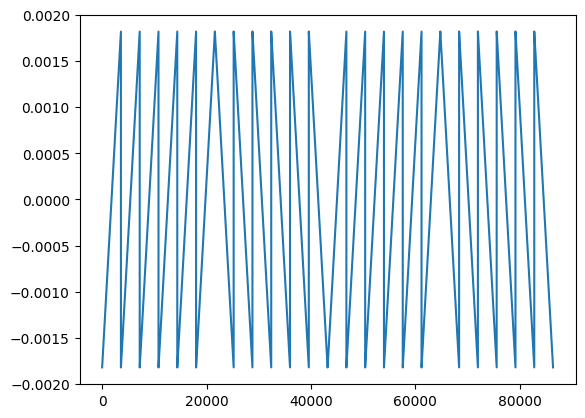

In [16]:
plt.plot(p3[1:12*7200])

In [15]:
np.mean(p2)

0.01091483851519431

In [30]:
np.mean(p3)

-7.018285179732076e-10

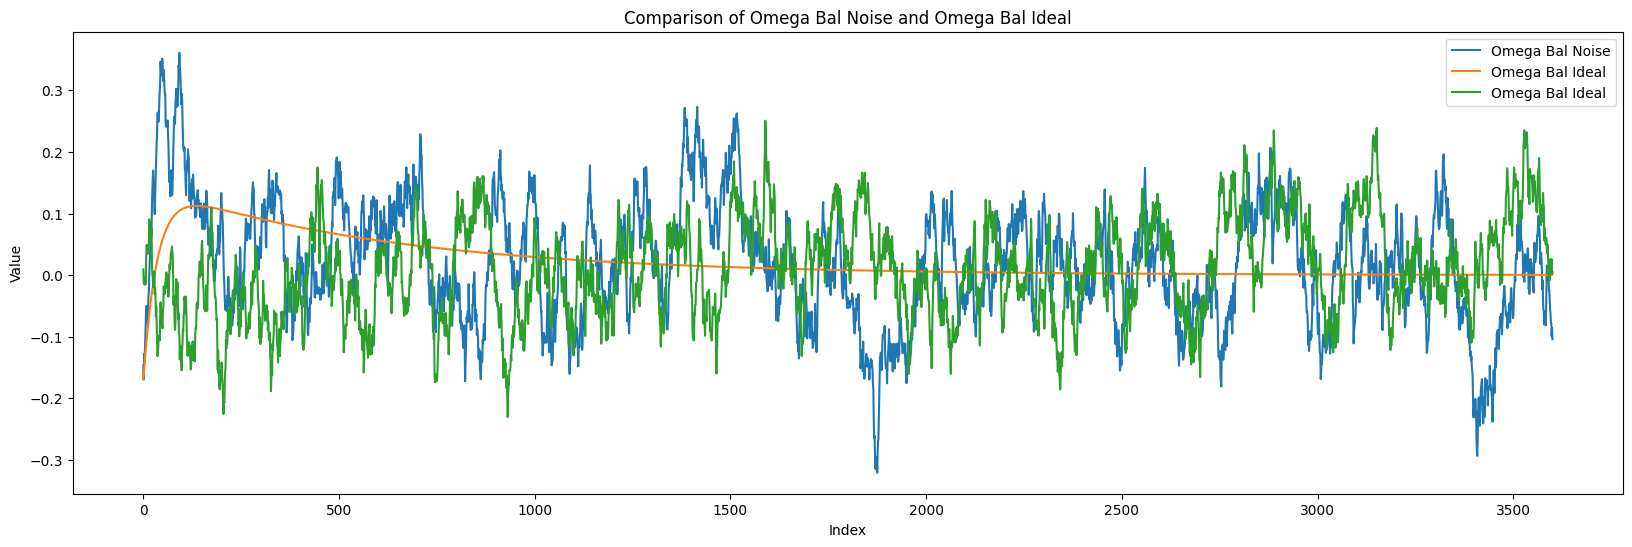

In [22]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

plt.plot(omega_Bal_noise[:900*4+1] ,label='Omega Bal Noise')
plt.plot(omega_Bal_ideal[:900*4+1],label='Omega Bal Ideal')
plt.plot(omega_Bal_time[:900*4+1],label='Omega Bal Ideal')

plt.legend()  # Show legend if multiple lines are plotted
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Omega Bal Noise and Omega Bal Ideal')

plt.show()

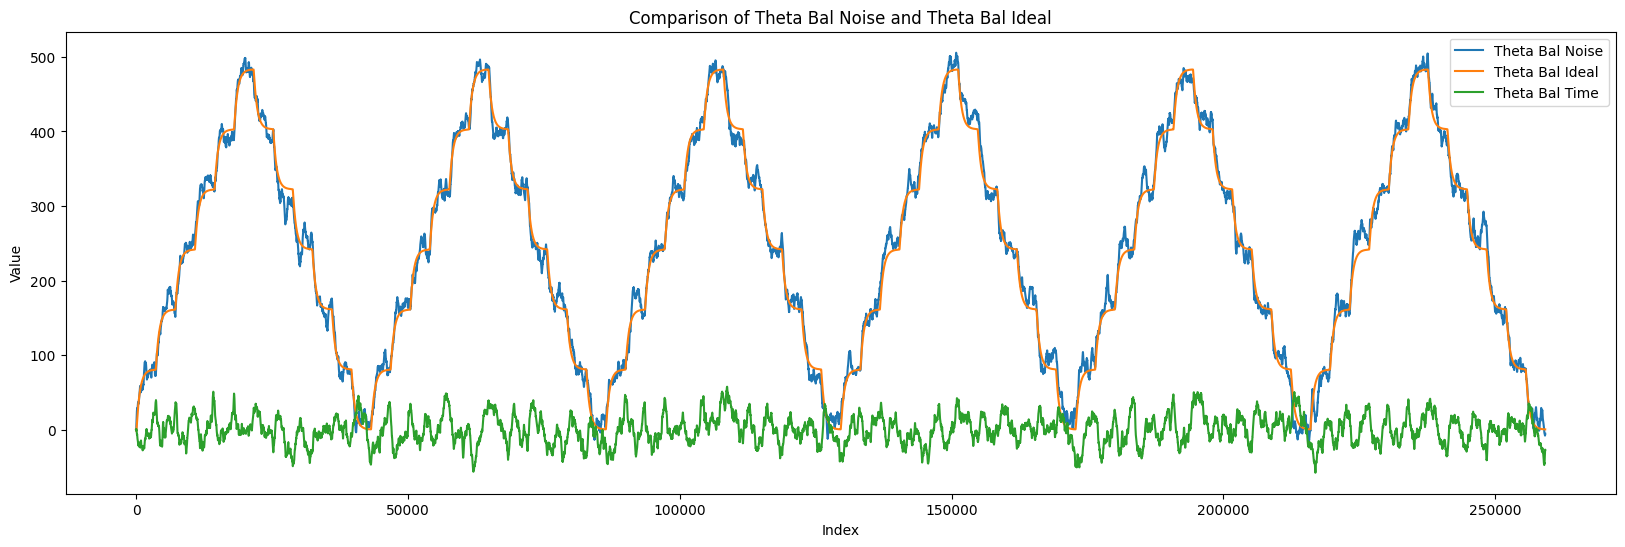

In [23]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

plt.plot(theta_Bal_noise[:900*96*3], label='Theta Bal Noise')
plt.plot(theta_Bal_ideal[:900*96*3], label='Theta Bal Ideal')
plt.plot(theta_Bal_time[:900*96*3], label='Theta Bal Time')

plt.legend()  # Show legend if multiple lines are plotted
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Theta Bal Noise and Theta Bal Ideal')

plt.show()

In [23]:
omega_df = pd.DataFrame({'omega': omega_Bal_ideal})
theta_df = pd.DataFrame({'theta': theta_Bal_ideal})

# Combine omega and theta DataFrames into a single DataFrame
combined_df = pd.concat([omega_df, theta_df], axis=1)

# Define the new list to hold the chunked DataFrames
chunked_data = []

# Number of points in each chunk
chunk_size = 900*4

# Calculate the number of chunks needed
num_chunks = len(combined_df) // chunk_size

# Split the DataFrame into chunks
for j in range(num_chunks):
    # Extract the chunk
    chunk = combined_df.iloc[j * chunk_size:(j + 1) * chunk_size].copy()

    # Label the chunk with the region name
    chunk['Region'] = 'Balearic'

    # Append the chunk to the list
    chunked_data.append(chunk)

# If there are remaining data points
if len(combined_df) % chunk_size != 0:
    remaining_chunk = combined_df.iloc[num_chunks * chunk_size:].copy()
    
    # Label the remaining chunk with the region name
    remaining_chunk['Region'] = 'Balearic'
    
    # Append the remaining chunk to the list
    chunked_data.append(remaining_chunk)




In [24]:
def calculate_sindy_models(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = chunk['theta'].values

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []

    # Iterate over each SINDy model in sindy_models
    for model in sindy_models:
        # Get the coefficients from the model
        coefficients = model.coefficients()

        # Append the coefficients to the list
        coefficients_matrices.append(coefficients)

    # Convert the list of matrices to a 3D NumPy array
    coefficients_array = np.array(coefficients_matrices)

    # Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    # Print mean_coefficients and std_coefficients 
    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients Coefficients for {region_name}:")
    print(std_coefficients)
    
    return sindy_models



In [25]:
def calculate_sindy_models_abs(region_data, region_name):
    sindy_models = []
    coefficients_matrices = []  # Initialize outside the models loop

    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = chunk['theta'].values

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    for model in sindy_models:
        coefficients = model.coefficients()
        feature_names = model.get_feature_names()

        # Handling the presence of specific features
        time_indices = [feature_names.index(f) for f in feature_names if 'time' in f]

        # Take the absolute value of specific coefficients
        for idx in time_indices:
            coefficients[:, idx] = np.abs(coefficients[:, idx])

        coefficients_matrices.append(coefficients)

    # Convert to a 3D NumPy array and calculate mean and standard deviation
    coefficients_array = np.array(coefficients_matrices)
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients for {region_name}:")
    print(std_coefficients)

    return sindy_models


In [42]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 4))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Linear Noise-Free', alpha=0.7, color='#2b6a99')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Linear Noise-Free and Simulated Omega - {title}', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Omega', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.legend(fontsize=16,frameon=False)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()


In [27]:
balearic_ideal = chunked_data
ideal_abs_models = calculate_sindy_models_abs(balearic_ideal, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = -0.0004394 1 + 0.0002647 theta + 1.0128179 omega + -0.0000322 time + -0.0000032 theta^2 + -0.0021034 theta omega + 0.0000004 theta time + -0.0662502 omega^2 + 0.0002480 omega time
(omega)' = 0.0036534 1 + -0.0000526 theta + -0.0298739 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000588 theta omega + 0.0018508 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666632717599

Model for Balearic - Chunk 2:
(theta)' = -0.0482049 1 + 0.0008524 theta + 1.2024910 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022269 theta omega + 0.0000004 theta time + -0.0635974 omega^2 + 0.0002475 omega time
(omega)' = 0.0085182 1 + -0.0000669 theta + -0.0346979 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016018 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639311308

Model for Balearic - Chunk 3:
(theta)' = -0.1392105 1 + 0.0014060 theta + 1.3820217 omega + -0.0000967 time + -0.000

Model for Balearic - Chunk 23:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 24:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 25:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000

Model for Balearic - Chunk 45:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 46:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 47:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.00

Model for Balearic - Chunk 67:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 68:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 69:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.000

Model for Balearic - Chunk 90:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 91:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 92:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.00

Model for Balearic - Chunk 113:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 114:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 115:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 135:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 136:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 137:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

Model Score: 0.666666663937446

Model for Balearic - Chunk 158:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 159:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 160:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.56

Model for Balearic - Chunk 179:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 180:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 181:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0

Model for Balearic - Chunk 201:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 202:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 203:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model Score: 0.6666666639310962

Model for Balearic - Chunk 223:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 224:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 225:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.305

Model for Balearic - Chunk 245:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 246:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 247:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 266:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 267:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 268:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + 

Model for Balearic - Chunk 288:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 289:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 290:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.00

Model Score: 0.6666666639310962

Model for Balearic - Chunk 311:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 312:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 313:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta

Model for Balearic - Chunk 331:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 332:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 333:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.

Model for Balearic - Chunk 354:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 355:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 356:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0

Model for Balearic - Chunk 376:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 377:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 378:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + 

Model for Balearic - Chunk 398:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 399:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 400:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + 

Model Score: 0.6666666639304484

Model for Balearic - Chunk 421:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 422:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 423:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.38

Model for Balearic - Chunk 443:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 444:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 445:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0

Model Score: 0.6666666639310962

Model for Balearic - Chunk 466:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 467:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 468:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8

Model for Balearic - Chunk 488:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 489:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 490:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.

Model for Balearic - Chunk 509:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 510:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 511:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model Score: 0.6666666639310962

Model for Balearic - Chunk 532:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 533:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 534:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9

Model for Balearic - Chunk 570:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 571:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 572:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0

Model Score: 0.6666666639310962

Model for Balearic - Chunk 592:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 593:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 594:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9

Model for Balearic - Chunk 614:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 615:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 616:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + 

Model for Balearic - Chunk 635:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 636:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 637:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0

Model for Balearic - Chunk 657:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 658:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 659:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model for Balearic - Chunk 679:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 680:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 681:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.

Model Score: 0.6666666639310962

Model for Balearic - Chunk 702:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 703:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 704:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.12

Mean Coefficients for Balearic:
[[-5.16975918e-03  2.34518864e-05  9.34315646e-01  9.67335157e-05
  -2.57006188e-08 -1.68690448e-05  3.97037255e-07 -5.33055705e-04
   2.45549164e-04  7.63171461e-13]
 [ 1.10696926e-02 -4.58562398e-05 -2.78515932e-02  2.45615952e-06
   7.23330609e-10  4.74802986e-07  1.02212267e-08  1.50101313e-05
   6.31691735e-06  1.98158081e-15]
 [ 1.00000000e+00 -9.77734295e-12 -3.16957710e-09  5.69755179e-13
   2.03269337e-14  1.31786883e-11  2.36632068e-15  3.76841642e-10
   1.46364087e-12  1.35005002e-20]]
Standard Deviation of Coefficients for Balearic:
[[3.51828699e-01 1.91234585e-03 6.20045719e-01 5.73789161e-05
  3.41254715e-06 2.21304668e-03 1.05474068e-08 6.31856929e-02
  6.57590293e-06 2.33961072e-13]
 [1.21363879e-02 4.86673937e-05 1.57619079e-02 1.44480843e-06
  8.82179140e-08 5.71583586e-05 2.95071042e-10 1.61997125e-03
  1.84017482e-07 6.67572305e-15]
 [1.36196363e-09 5.47350961e-12 1.83685128e-09 3.33741564e-13
  6.21188979e-16 3.99937300e-13 6.8823606

In [ ]:
#['1', 'theta', 'omega','time',
# 'theta^2','theta omega','theta time','omega^2',
# 'omega time','time^2']

In [28]:
balearic_ideal = chunked_data
balearic_models = calculate_sindy_models(balearic_ideal, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = -0.0004394 1 + 0.0002647 theta + 1.0128179 omega + -0.0000322 time + -0.0000032 theta^2 + -0.0021034 theta omega + 0.0000004 theta time + -0.0662502 omega^2 + 0.0002480 omega time
(omega)' = 0.0036534 1 + -0.0000526 theta + -0.0298739 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000588 theta omega + 0.0018508 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666632717599

Model for Balearic - Chunk 2:
(theta)' = -0.0482049 1 + 0.0008524 theta + 1.2024910 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022269 theta omega + 0.0000004 theta time + -0.0635974 omega^2 + 0.0002475 omega time
(omega)' = 0.0085182 1 + -0.0000669 theta + -0.0346979 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016018 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639311308

Model for Balearic - Chunk 3:
(theta)' = -0.1392105 1 + 0.0014060 theta + 1.3820217 omega + -0.0000967 time + -0.000

Model for Balearic - Chunk 22:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 23:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 24:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0

Model for Balearic - Chunk 43:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 44:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 45:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.000

Model for Balearic - Chunk 66:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 67:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 68:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.00

Model for Balearic - Chunk 90:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 91:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 92:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.00

Model for Balearic - Chunk 113:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 114:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 115:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 135:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 136:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 137:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

Model for Balearic - Chunk 157:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 158:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 159:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -

Model for Balearic - Chunk 179:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 180:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 181:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0

Model Score: 0.6666666639310962

Model for Balearic - Chunk 203:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 204:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 205:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta

Model for Balearic - Chunk 225:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 226:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 227:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model Score: 0.6666666639310962

Model for Balearic - Chunk 247:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 248:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 249:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.305

Model for Balearic - Chunk 269:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 270:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 271:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 291:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 292:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 293:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

Model for Balearic - Chunk 313:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 314:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 315:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -

Model for Balearic - Chunk 334:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 335:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 336:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 

Model for Balearic - Chunk 357:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 358:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 359:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model Score: 0.666666663930108

Model for Balearic - Chunk 380:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 381:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 382:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847

Model for Balearic - Chunk 401:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 402:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 403:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 424:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 425:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 426:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + 

Model for Balearic - Chunk 446:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636148 omega^2 + 0.0002475 omega time
(omega)' = 0.0085187 1 + -0.0000669 theta + -0.0347000 omega + 0.0000016 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 447:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 448:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + 

Model for Balearic - Chunk 468:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 469:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 470:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.00

Model for Balearic - Chunk 491:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 492:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 493:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0

Model for Balearic - Chunk 512:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 513:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 514:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.

Model for Balearic - Chunk 534:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 535:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 536:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0

Model for Balearic - Chunk 556:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 557:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 558:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + 

Model Score: 0.6666666639310934

Model for Balearic - Chunk 579:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 580:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 581:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7

Model for Balearic - Chunk 600:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 + 0.0020226 theta omega + 0.0000004 theta time + 0.0572528 omega^2 + 0.0002237 omega time
(omega)' = -0.0000388 theta + -0.0255788 omega + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639304484

Model for Balearic - Chunk 601:
(theta)' = -0.0019568 1 + 0.0003025 theta + 1.0241922 omega + -0.0000322 time + -0.0000035 theta^2 + -0.0022408 theta omega + 0.0000004 theta time + -0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0036958 1 + -0.0000537 theta + -0.0301921 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000627 theta omega + 0.0017929 omega^2 + -0.0000069 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663937446

Model for Balearic - Chunk 602:
(theta)' = -0.0482254 1 + 0.0008526 theta + 1.2025742 omega + -0.0000645 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.00

Model for Balearic - Chunk 622:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 623:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0025578 1 + -0.0000247 theta + -0.0210184 omega + 0.0000008 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 624:
(theta)' = 0.0000011 1 + -0.0002289 theta + 0.8593475 omega + 0.0000031 theta^2 

Model for Balearic - Chunk 645:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0042705 1 + 0.0000034 theta + -0.0118974 omega + 0.0000024 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 646:
(theta)' = 0.1301477 1 + -0.0013610 theta + 0.4847499 omega + -0.0000645 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636136 omega^2 + 0.0002475 omega time
(omega)' = 0.0039813 1 + -0.0000106 theta + -0.0164579 omega + 0.0000016 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 647:
(theta)' = 0.0427860 1 + -0.0008076 theta + 0.6642045 omega + -0.0000323 time + 0

Model for Balearic - Chunk 667:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time + 0.0000035 theta^2 + 0.0022408 theta omega + 0.0000004 theta time + 0.0640685 omega^2 + 0.0002475 omega time
(omega)' = 0.0013615 1 + 0.0000320 theta + -0.0026392 omega + 0.0000041 time + -0.0000001 theta^2 + -0.0000569 theta omega + -0.0016138 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.666666663930108

Model for Balearic - Chunk 668:
(theta)' = 0.4386387 1 + -0.0024679 theta + 0.1258283 omega + -0.0001290 time + 0.0000034 theta^2 + 0.0022274 theta omega + 0.0000004 theta time + 0.0636149 omega^2 + 0.0002475 omega time
(omega)' = 0.0034253 1 + 0.0000175 theta + -0.0073366 omega + 0.0000033 time + -0.0000001 theta^2 + -0.0000566 theta omega + -0.0016023 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310934

Model for Balearic - Chunk 669:
(theta)' = 0.2620966 1 + -0.0019144 theta + 0.3052952 omega + -0.0000967 time + 0.

Model for Balearic - Chunk 689:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636138 omega^2 + 0.0002475 omega time
(omega)' = 0.0298041 1 + -0.0001092 theta + -0.0483813 omega + 0.0000041 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 690:
(theta)' = -0.6796920 1 + 0.0030662 theta + 1.9203828 omega + -0.0001935 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636133 omega^2 + 0.0002475 omega time
(omega)' = 0.0391678 1 + -0.0001233 theta + -0.0529418 omega + 0.0000049 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 691:
(theta)' = 0.6630839 1 + -0.0030378 theta + -0.0590280 omega + -0.0001612 time +

Model for Balearic - Chunk 711:
(theta)' = -0.1392106 1 + 0.0014060 theta + 1.3820221 omega + -0.0000967 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636135 omega^2 + 0.0002475 omega time
(omega)' = 0.0144795 1 + -0.0000810 theta + -0.0392603 omega + 0.0000024 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 712:
(theta)' = -0.2747844 1 + 0.0019594 theta + 1.5614761 omega + -0.0001290 time + -0.0000034 theta^2 + -0.0022274 theta omega + 0.0000004 theta time + -0.0636134 omega^2 + 0.0002475 omega time
(omega)' = 0.0215746 1 + -0.0000951 theta + -0.0438208 omega + 0.0000033 time + 0.0000001 theta^2 + 0.0000566 theta omega + 0.0016022 omega^2 + -0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.6666666639310962

Model for Balearic - Chunk 713:
(theta)' = -0.4549475 1 + 0.0025129 theta + 1.7409338 omega + -0.0001612 time + 

In [24]:
c_1_model2

{'Balearic': array([-0.0295151]),
 'Irish': array([-0.023064]),
 'Iceland': array([-0.00964162])}

In [32]:
c_2_model2

{'Balearic': array([-4.51579245e-05]),
 'Irish': array([-6.34585943e-07]),
 'Iceland': array([-0.])}

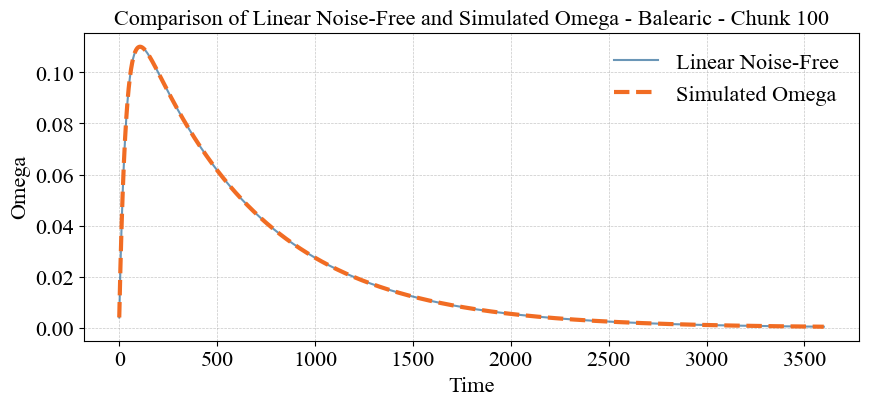

In [43]:
plt.rcParams['font.family'] = 'Times New Roman'
n = 99 

# Extract initial conditions consistently
initial_conditions = [balearic_ideal[n]['theta'].values[0], 
                      balearic_ideal[n]['omega'].values[0],0]

# Define time points for simulation
total_time = len(balearic_ideal[n]['omega'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original is available
omega_original = balearic_ideal[n]['omega'].values  # Replace 'omega' with the actual column name

# Simulate and plot results for a specific chunk (e.g., chunk n+1)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original)


# balearic noise


In [44]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter(data, chunk_size=900*4, sigma=60):
    # Create DataFrame
    data_df = pd.DataFrame({'omega': data})

    # Define the list to hold the filtered DataFrames
    filtered_data = []

    # Calculate the number of chunks needed
    num_chunks = len(data_df) // chunk_size

    # Split the DataFrame into chunks and apply the Gaussian filter to each chunk
    for j in range(num_chunks):
        # Extract the chunk
        chunk = data_df.iloc[j*chunk_size:(j+1)*chunk_size].copy()
        
        # Apply Gaussian filter to the 'omega' column
        chunk['omega_filtered'] = gaussian_filter1d(chunk['omega'], sigma=sigma)
        
        # Label the chunk with 'balearic'
        chunk['Region'] = 'balearic'
        
        # Append the filtered chunk to the list
        filtered_data.append(chunk)

    # If there are remaining data points
    if len(data_df) % chunk_size != 0:
        remaining_chunk = data_df.iloc[num_chunks*chunk_size:].copy()
        remaining_chunk['omega_filtered'] = gaussian_filter1d(remaining_chunk['omega'], sigma=sigma)
        
        # Label the remaining chunk with 'balearic'
        remaining_chunk['Region'] = 'balearic'
        
        # Append the remaining chunk to the list
        filtered_data.append(remaining_chunk)
    
    return filtered_data

In [45]:
def calculate_sindy_models(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])
        #x_train_augmented_chunk = np.hstack([stacked_data_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]
        #feature_names_chunk = ["theta", "omega"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []

    # Iterate over each SINDy model in sindy_models
    for model in sindy_models:
        # Get the coefficients from the model
        coefficients = model.coefficients()

        # Append the coefficients to the list
        coefficients_matrices.append(coefficients)

    # Convert the list of matrices to a 3D NumPy array
    coefficients_array = np.array(coefficients_matrices)

    # Calculate mean and standard deviation along the first axis (axis=0) which corresponds to chunks
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    # Print or use mean_coefficients and std_coefficients as needed
    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients Coefficients for {region_name}:")
    print(std_coefficients)
    
    return sindy_models

In [46]:
def simulate_sindy_model(model, initial_conditions, time_points, title, omega_original, omega_filtered):
    # Simulate the system using the provided model
    simulated_data = model.simulate(initial_conditions, time_points)

    # Extract simulated theta and omega
    simulated_theta = simulated_data[:, 0]
    simulated_omega = simulated_data[:, 1]

    # Plot the simulation results
    plt.figure(figsize=(10, 6))

    # Plot the original Omega with noise
    plt.plot(omega_original, label='Original Omega with noise', alpha=0.7, color='#2b6a99')

    # Plot the Gaussian Filtered Omega
    plt.plot(omega_filtered, label='Gaussian Filtered Omega', linestyle='-', linewidth=2, color='#1b7c3d')

    # Plot the simulated Omega
    plt.plot(simulated_omega, label='Simulated Omega', linestyle='--', linewidth=3, color='#f16c23')

    plt.title(f'Comparison of Original, Filtered, and Simulated Omega - {title}')
    plt.xlabel('Time')
    plt.ylabel('Omega')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

In [47]:
def calculate_sindy_models_abs(region_data, region_name):
    # Initialize an empty list for sindy_models
    sindy_models = []

    # Iterate over each chunk
    for chunk in region_data:
        # Integrate omega_filtered to get theta
        theta_chunk = integrate_data(chunk['omega_filtered'].values)

        # Stack normalized theta and omega_filtered
        stacked_data_chunk = np.column_stack((theta_chunk, chunk['omega_filtered'].values))

        # Generate time values
        t_train_chunk = np.arange(0, len(stacked_data_chunk), 1)

        # Add time as a linear feature
        linear_time_feature_chunk = t_train_chunk.reshape(-1, 1)
        x_train_augmented_chunk = np.hstack([stacked_data_chunk, linear_time_feature_chunk])

        # Feature names for SINDy (including a linear term for time)
        feature_names_chunk = ["theta", "omega", "time"]

        # Use Polynomial Library 
        polynomial_library_chunk = ps.PolynomialLibrary(degree=2)

        # Sparse regression optimizer
        sparse_regression_optimizer_chunk = ps.STLSQ(threshold=1e-10)

        # Create a SINDy model with the polynomial library
        model_chunk = ps.SINDy(feature_names=feature_names_chunk, 
                               feature_library=polynomial_library_chunk,
                               optimizer=sparse_regression_optimizer_chunk)

        # Fit the SINDy model using the chunk data
        model_chunk.fit(x_train_augmented_chunk, t=1)

        # Append the SINDy model to the list
        sindy_models.append(model_chunk)

        # Print the learned model for the current chunk
        print(f"Model for {region_name} - Chunk {len(sindy_models)}:")
        model_chunk.print(precision=7)
        print("Model Score:", model_chunk.score(x_train_augmented_chunk, t=1))
        print()

    # Initialize empty lists for coefficient matrices
    coefficients_matrices = []
    
    for model in sindy_models:
        coefficients = model.coefficients()
        feature_names = model.get_feature_names()

        # Handling the presence of specific features
        time_indices = [feature_names.index(f) for f in feature_names if 'time' in f]

        # Take the absolute value of specific coefficients
        for idx in time_indices:
            coefficients[:, idx] = np.abs(coefficients[:, idx])

        coefficients_matrices.append(coefficients)

    # Convert to a 3D NumPy array and calculate mean and standard deviation
    coefficients_array = np.array(coefficients_matrices)
    mean_coefficients = np.mean(coefficients_array, axis=0)
    std_coefficients = np.std(coefficients_array, axis=0)

    print(f"Mean Coefficients for {region_name}:")
    print(mean_coefficients)
    print(f"Standard Deviation of Coefficients for {region_name}:")
    print(std_coefficients)

    return sindy_models


In [48]:
omega_Bal_noise_filtered = apply_gaussian_filter(omega_Bal_noise, sigma=60)
balearic_data = [chunk for chunk in omega_Bal_noise_filtered if chunk['Region'].iloc[0] == 'balearic']
noise_models = calculate_sindy_models_abs(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = 0.0003850 1 + -0.0000316 theta + 0.9968328 omega + 0.0000017 time + 0.0000002 theta^2 + 0.0000257 theta omega + 0.0084783 omega^2 + 0.0000005 omega time
(omega)' = 0.0007367 1 + -0.0000622 theta + -0.0060950 omega + 0.0000034 time + 0.0000004 theta^2 + 0.0000479 theta omega + 0.0168107 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.47142923767834377

Model for Balearic - Chunk 2:
(theta)' = 0.0003901 1 + -0.0000390 theta + 0.9996671 omega + 0.0000024 time + 0.0000139 theta omega + -0.0031305 omega^2 + -0.0000005 omega time
(omega)' = 0.0007580 1 + -0.0000773 theta + -0.0005083 omega + 0.0000047 time + 0.0000262 theta omega + -0.0060913 omega^2 + -0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.4396346837594442

Model for Balearic - Chunk 3:
(theta)' = 0.0006349 1 + -0.0000588 theta + 0.9946047 omega + 0.0000033 time + 0.0000006 theta^2 + 0.0000301 theta omega + 0.0243691 omega^2 + 0.0000008 omega time
(omega)' = 0.

Model for Balearic - Chunk 37:
(theta)' = 0.0002990 1 + -0.0000335 theta + 0.9962301 omega + 0.0000013 time + 0.0000004 theta^2 + 0.0000493 theta omega + 0.0229134 omega^2 + -0.0000002 omega time
(omega)' = 0.0005845 1 + -0.0000666 theta + -0.0073156 omega + 0.0000027 time + 0.0000007 theta^2 + 0.0000961 theta omega + 0.0454449 omega^2 + -0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.42034882997879314

Model for Balearic - Chunk 38:
(theta)' = 0.0008604 1 + -0.0000039 theta + 0.9924005 omega + -0.0000002 theta^2 + 0.0000947 theta omega + 0.0050599 omega^2 + 0.0000002 omega time
(omega)' = 0.0017133 1 + -0.0000033 theta + -0.0152074 omega + -0.0000001 time + -0.0000005 theta^2 + 0.0001903 theta omega + 0.0087909 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.47554912530302057

Model for Balearic - Chunk 39:
(theta)' = 0.0002358 1 + -0.0000305 theta + 0.9960226 omega + 0.0000012 time + 0.0000005 theta^2 + 0.0000235 theta omega + 0.0283950 omega^2 + 0.0000

Model for Balearic - Chunk 57:
(theta)' = 0.0002039 1 + -0.0000146 theta + 1.0047019 omega + -0.0000012 time + -0.0000001 theta^2 + 0.0001512 theta omega + -0.0044538 omega^2 + 0.0000021 omega time
(omega)' = 0.0004144 1 + -0.0000283 theta + 0.0094884 omega + -0.0000023 time + -0.0000001 theta^2 + 0.0003033 theta omega + -0.0087804 omega^2 + 0.0000041 omega time
(time)' = 1.0000000 1
Model Score: 0.5144223817159558

Model for Balearic - Chunk 58:
(theta)' = -0.0004458 1 + 0.0000226 theta + 0.9964192 omega + -0.0000008 time + 0.0000008 theta^2 + -0.0000581 theta omega + 0.0188767 omega^2 + -0.0000002 omega time
(omega)' = -0.0008790 1 + 0.0000451 theta + -0.0069790 omega + -0.0000015 time + 0.0000016 theta^2 + -0.0001169 theta omega + 0.0384689 omega^2 + -0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4877812099235134

Model for Balearic - Chunk 59:
(theta)' = -0.0005828 1 + 0.0000446 theta + 0.9956743 omega + 0.0000014 time + 0.0000010 theta^2 + -0.0000360 theta omega + 0.02

Model for Balearic - Chunk 94:
(theta)' = -0.0005633 1 + -0.0000283 theta + 0.9957343 omega + -0.0000009 time + -0.0000601 theta omega + 0.0018351 omega^2 + 0.0000001 omega time
(omega)' = -0.0011020 1 + -0.0000559 theta + -0.0083718 omega + -0.0000018 time + -0.0000001 theta^2 + -0.0001191 theta omega + 0.0035813 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.4243130489805196

Model for Balearic - Chunk 95:
(theta)' = 0.0003209 1 + -0.0000017 theta + 1.0055153 omega + -0.0000010 time + -0.0000001 theta^2 + 0.0001237 theta omega + 0.0125671 omega^2 + 0.0000020 omega time
(omega)' = 0.0006817 1 + -0.0000024 theta + 0.0112260 omega + -0.0000021 time + -0.0000001 theta^2 + 0.0002505 theta omega + 0.0250379 omega^2 + 0.0000041 omega time
(time)' = 1.0000000 1
Model Score: 0.44273848712012825

Model for Balearic - Chunk 96:
(theta)' = 0.0000482 1 + -0.0000117 theta + 1.0001515 omega + -0.0000019 time + 0.0000002 theta^2 + 0.0000018 theta omega + 0.0110707 omega^2 + 0.00

Model for Balearic - Chunk 130:
(theta)' = 0.0001501 1 + -0.0000093 theta + 1.0018385 omega + -0.0000012 time + -0.0000001 theta^2 + 0.0000219 theta omega + 0.0007856 omega^2 + -0.0000003 omega time
(omega)' = 0.0003214 1 + -0.0000182 theta + 0.0038225 omega + -0.0000025 time + -0.0000002 theta^2 + 0.0000452 theta omega + 0.0015824 omega^2 + -0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.4579246652540789

Model for Balearic - Chunk 131:
(theta)' = -0.0000924 1 + -0.0000158 theta + 1.0034583 omega + -0.0000015 time + -0.0000001 theta^2 + 0.0000481 theta omega + 0.0075606 omega^2 + 0.0000009 omega time
(omega)' = -0.0001783 1 + -0.0000317 theta + 0.0069137 omega + -0.0000030 time + -0.0000002 theta^2 + 0.0000963 theta omega + 0.0148299 omega^2 + 0.0000019 omega time
(time)' = 1.0000000 1
Model Score: 0.46423526239091856

Model for Balearic - Chunk 132:
(theta)' = 0.0002421 1 + 0.0000327 theta + 1.0020617 omega + 0.0000001 time + 0.0000006 theta^2 + 0.0000722 theta omega + 0.0

Model for Balearic - Chunk 167:
(theta)' = -0.0001093 1 + -0.0000672 theta + 1.0023253 omega + -0.0000048 time + -0.0000005 theta^2 + 0.0000330 theta omega + 0.0117432 omega^2 + 0.0000003 omega time
(omega)' = -0.0002137 1 + -0.0001347 theta + 0.0047435 omega + -0.0000096 time + -0.0000010 theta^2 + 0.0000661 theta omega + -0.0000001 theta time + 0.0235330 omega^2 + 0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.49089105392596677

Model for Balearic - Chunk 168:
(theta)' = -0.0004606 1 + -0.0000176 theta + 0.9945049 omega + -0.0000010 time + -0.0000001 theta^2 + -0.0000560 theta omega + -0.0157949 omega^2
(omega)' = -0.0007581 1 + -0.0000278 theta + -0.0091614 omega + -0.0000018 time + -0.0000001 theta^2 + -0.0001048 theta omega + -0.0237629 omega^2 + -0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4234746591731504

Model for Balearic - Chunk 169:
(theta)' = -0.0002132 1 + -0.0000138 theta + 1.0005380 omega + 0.0000014 time + -0.0000003 theta^2 + -0.0000732 theta 

Model for Balearic - Chunk 204:
(theta)' = -0.0002527 1 + -0.0000280 theta + 0.9990245 omega + -0.0000009 time + -0.0000001 theta^2 + -0.0000296 theta omega + -0.0025799 omega^2 + -0.0000003 omega time
(omega)' = -0.0004989 1 + -0.0000560 theta + -0.0018571 omega + -0.0000018 time + -0.0000003 theta^2 + -0.0000580 theta omega + -0.0051932 omega^2 + -0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.4196598533555729

Model for Balearic - Chunk 205:
(theta)' = 0.0010305 1 + -0.0000065 theta + 0.9962025 omega + 0.0000002 time + -0.0000008 theta^2 + 0.0000468 theta omega + -0.0095892 omega^2 + 0.0000003 omega time
(omega)' = 0.0020333 1 + -0.0000121 theta + -0.0074533 omega + 0.0000005 time + -0.0000016 theta^2 + 0.0000910 theta omega + 0.0000001 theta time + -0.0190863 omega^2 + 0.0000008 omega time
(time)' = 1.0000000 1
Model Score: 0.49109053059975194

Model for Balearic - Chunk 206:
(theta)' = -0.0001707 1 + 0.0000278 theta + 1.0062653 omega + -0.0000001 time + -0.0000006 theta

Model Score: 0.45528096729909473

Model for Balearic - Chunk 241:
(theta)' = 0.0002130 1 + -0.0000195 theta + 0.9994962 omega + 0.0000010 time + 0.0000002 theta^2 + 0.0000180 theta omega + -0.0043168 omega^2 + -0.0000005 omega time
(omega)' = 0.0003885 1 + -0.0000397 theta + -0.0000946 omega + 0.0000020 time + 0.0000004 theta^2 + 0.0000370 theta omega + -0.0129689 omega^2 + -0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.438532793404971

Model for Balearic - Chunk 242:
(theta)' = 0.0001789 1 + -0.0000142 theta + 0.9994018 omega + 0.0000004 time + -0.0000005 theta^2 + -0.0001047 theta omega + 0.0047976 omega^2 + 0.0000032 omega time
(omega)' = 0.0003462 1 + -0.0000275 theta + -0.0010121 omega + 0.0000007 time + -0.0000011 theta^2 + -0.0002095 theta omega + 0.0000001 theta time + 0.0089607 omega^2 + 0.0000063 omega time
(time)' = 1.0000000 1
Model Score: 0.4449870139161707

Model for Balearic - Chunk 243:
(theta)' = 0.0006324 1 + -0.0000088 theta + 0.9909760 omega + 0.0000003 

Model for Balearic - Chunk 277:
(theta)' = 0.0002636 1 + -0.0000461 theta + 1.0003678 omega + 0.0000021 time + 0.0000004 theta^2 + 0.0000102 theta omega + -0.0021865 omega^2 + -0.0000007 omega time
(omega)' = 0.0005234 1 + -0.0000921 theta + 0.0007647 omega + 0.0000042 time + 0.0000008 theta^2 + 0.0000204 theta omega + -0.0042129 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.47955977388418947

Model for Balearic - Chunk 278:
(theta)' = 0.0001303 1 + -0.0000169 theta + 1.0017634 omega + 0.0000013 time + 0.0000001 theta^2 + 0.0000022 theta omega + -0.0209395 omega^2 + -0.0000006 omega time
(omega)' = -0.0001411 1 + -0.0000306 theta + 0.0103718 omega + 0.0000037 time + -0.0000001 theta^2 + 0.0000354 theta omega + -0.0803448 omega^2 + -0.0000053 omega time
(time)' = 1.0000000 1
Model Score: 0.4980765782260798

Model for Balearic - Chunk 279:
(theta)' = 0.0009128 1 + -0.0000183 theta + 0.9925988 omega + 0.0000002 time + 0.0000001 theta^2 + 0.0000640 theta omega + 0.01

Model for Balearic - Chunk 313:
(theta)' = 0.0001175 1 + -0.0000696 theta + 0.9993905 omega + 0.0000028 time + 0.0000004 theta^2 + 0.0000997 theta omega + 0.0035813 omega^2 + -0.0000031 omega time
(omega)' = 0.0002287 1 + -0.0001391 theta + -0.0010596 omega + 0.0000057 time + 0.0000008 theta^2 + 0.0001950 theta omega + 0.0067805 omega^2 + -0.0000062 omega time
(time)' = 1.0000000 1
Model Score: 0.49845629927463314

Model for Balearic - Chunk 314:
(theta)' = -0.0004477 1 + 0.0000081 theta + 1.0006658 omega + 0.0000011 time + -0.0000002 theta^2 + -0.0000438 theta omega + 0.0134159 omega^2 + 0.0000014 omega time
(omega)' = -0.0009265 1 + 0.0000166 theta + 0.0016325 omega + 0.0000022 time + -0.0000004 theta^2 + -0.0000892 theta omega + 0.0263155 omega^2 + 0.0000028 omega time
(time)' = 1.0000000 1
Model Score: 0.40792178974769966

Model for Balearic - Chunk 315:
(theta)' = 0.0006094 1 + -0.0000512 theta + 0.9900700 omega + 0.0000045 time + 0.0000003 theta^2 + 0.0000824 theta omega + 0.0279

Model for Balearic - Chunk 350:
(theta)' = 0.0001521 1 + -0.0000034 theta + 0.9983759 omega + 0.0000005 time + -0.0000001 theta^2 + -0.0000045 theta omega + -0.0008754 omega^2 + 0.0000011 omega time
(omega)' = 0.0002944 1 + -0.0000110 theta + -0.0029134 omega + 0.0000010 time + -0.0000123 theta omega + 0.0000197 omega^2 + 0.0000020 omega time
(time)' = 1.0000000 1
Model Score: 0.45951031946125714

Model for Balearic - Chunk 351:
(theta)' = 0.0001186 1 + -0.0000102 theta + 0.9999992 omega + 0.0000004 time + 0.0000001 theta^2 + 0.0000154 theta omega + -0.0079326 omega^2 + -0.0000006 omega time
(omega)' = -0.0000435 1 + -0.0000430 theta + 0.0024867 omega + 0.0000032 time + -0.0000281 theta omega + -0.0195656 omega^2 + 0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.45924956663338284

Model for Balearic - Chunk 352:
(theta)' = 0.0002349 1 + -0.0000706 theta + 0.9967328 omega + 0.0000046 time + 0.0000005 theta^2 + 0.0000378 theta omega + 0.0124375 omega^2 + -0.0000003 omega time
(

Model for Balearic - Chunk 385:
(theta)' = -0.0000635 1 + -0.0000263 theta + 1.0020477 omega + 0.0000016 time + -0.0000267 theta omega + -0.0098191 omega^2
(omega)' = -0.0001324 1 + -0.0000524 theta + 0.0041897 omega + 0.0000032 time + -0.0000545 theta omega + -0.0199603 omega^2
(time)' = 1.0000000 1
Model Score: 0.449707123507076

Model for Balearic - Chunk 386:
(theta)' = -0.0003175 1 + -0.0000091 theta + 1.0026467 omega + 0.0000016 time + -0.0000381 theta omega + 0.0026389 omega^2
(omega)' = -0.0006581 1 + -0.0000179 theta + 0.0056003 omega + 0.0000031 time + -0.0000001 theta^2 + -0.0000797 theta omega + 0.0052142 omega^2
(time)' = 1.0000000 1
Model Score: 0.5084672896884116

Model for Balearic - Chunk 387:
(theta)' = 0.0005887 1 + -0.0000308 theta + 0.9987234 omega + 0.0000009 time + 0.0000003 theta^2 + -0.0000061 theta omega + -0.0000946 omega^2 + 0.0000006 omega time
(omega)' = 0.0011871 1 + -0.0000593 theta + -0.0028526 omega + 0.0000018 time + 0.0000006 theta^2 + -0.0000003 the

Model for Balearic - Chunk 421:
(theta)' = 0.0001755 1 + 0.0000069 theta + 0.9964599 omega + 0.0000001 time + -0.0000002 theta^2 + 0.0000222 theta omega + 0.0036037 omega^2 + 0.0000007 omega time
(omega)' = 0.0003187 1 + 0.0000142 theta + -0.0067441 omega + 0.0000001 time + -0.0000004 theta^2 + 0.0000406 theta omega + 0.0068529 omega^2 + 0.0000015 omega time
(time)' = 1.0000000 1
Model Score: 0.38779045058070777

Model for Balearic - Chunk 422:
(theta)' = 0.0003247 1 + -0.0000527 theta + 1.0027209 omega + 0.0000032 time + 0.0000003 theta^2 + 0.0000431 theta omega + -0.0267675 omega^2 + -0.0000030 omega time
(omega)' = 0.0006339 1 + -0.0001049 theta + 0.0055164 omega + 0.0000063 time + 0.0000005 theta^2 + 0.0000846 theta omega + -0.0530725 omega^2 + -0.0000060 omega time
(time)' = 1.0000000 1
Model Score: 0.4879769164812531

Model for Balearic - Chunk 423:
(theta)' = -0.0001534 1 + 0.0000083 theta + 1.0002661 omega + 0.0000002 time + -0.0000001 theta^2 + -0.0000419 theta omega + 0.00466

Model for Balearic - Chunk 457:
(theta)' = 0.0004462 1 + -0.0000193 theta + 0.9994019 omega + 0.0000007 time + 0.0000002 theta^2 + 0.0000057 theta omega + -0.0025471 omega^2 + -0.0000001 omega time
(omega)' = 0.0009088 1 + -0.0000436 theta + -0.0022616 omega + 0.0000015 time + 0.0000005 theta^2 + -0.0000035 theta omega + 0.0040211 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4145082691800764

Model for Balearic - Chunk 458:
(theta)' = -0.0002844 1 + -0.0000049 theta + 1.0022634 omega + 0.0000014 time + -0.0000444 theta omega + 0.0048055 omega^2 + 0.0000006 omega time
(omega)' = -0.0005783 1 + -0.0000099 theta + 0.0046365 omega + 0.0000029 time + -0.0000891 theta omega + 0.0094796 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4478414564561783

Model for Balearic - Chunk 459:
(theta)' = -0.0002155 1 + -0.0000205 theta + 1.0011681 omega + 0.0000025 time + 0.0000002 theta^2 + -0.0000033 theta omega + -0.0045200 omega^2 + -0.0000007 omega time
(o

Model for Balearic - Chunk 495:
(theta)' = 0.0000751 1 + -0.0000159 theta + 0.9991288 omega + 0.0000009 time + 0.0000104 theta omega + 0.0104176 omega^2 + -0.0000002 omega time
(omega)' = 0.0001418 1 + -0.0000320 theta + -0.0015894 omega + 0.0000017 time + 0.0000194 theta omega + 0.0207994 omega^2 + -0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.4392952764932934

Model for Balearic - Chunk 496:
(theta)' = 0.0000333 1 + -0.0000312 theta + 1.0003145 omega + 0.0000017 time + 0.0000001 theta^2 + 0.0000167 theta omega + -0.0046158 omega^2 + -0.0000007 omega time
(omega)' = 0.0000632 1 + -0.0000623 theta + 0.0006815 omega + 0.0000035 time + 0.0000001 theta^2 + 0.0000319 theta omega + -0.0090975 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4436240278474088

Model for Balearic - Chunk 497:
(theta)' = 0.0002074 1 + -0.0000477 theta + 0.9975986 omega + 0.0000045 time + 0.0000002 theta^2 + -0.0000257 theta omega + 0.0179726 omega^2 + 0.0000025 omega time
(omega

Model for Balearic - Chunk 531:
(theta)' = 0.0001250 1 + -0.0000109 theta + 1.0013903 omega + 0.0000005 time + -0.0000001 theta^2 + -0.0000593 theta omega + 0.0014034 omega^2 + 0.0000012 omega time
(omega)' = 0.0002404 1 + -0.0000216 theta + 0.0029167 omega + 0.0000010 time + -0.0000001 theta^2 + -0.0001213 theta omega + 0.0027028 omega^2 + 0.0000024 omega time
(time)' = 1.0000000 1
Model Score: 0.4245460751682348

Model for Balearic - Chunk 532:
(theta)' = -0.0000272 1 + 0.0000035 theta + 1.0022699 omega + 0.0000009 time + -0.0000003 theta^2 + -0.0001156 theta omega + -0.0051346 omega^2 + 0.0000033 omega time
(omega)' = -0.0000692 1 + 0.0000070 theta + 0.0047153 omega + 0.0000018 time + -0.0000006 theta^2 + -0.0002335 theta omega + -0.0103125 omega^2 + 0.0000066 omega time
(time)' = 1.0000000 1
Model Score: 0.4442971228965747

Model for Balearic - Chunk 533:
(theta)' = 0.0006660 1 + -0.0000133 theta + 0.9933158 omega + 0.0000005 time + 0.0000001 theta^2 + 0.0000270 theta omega + 0.014

Model Score: 0.36867932400007913

Model for Balearic - Chunk 551:
(theta)' = 0.0001569 1 + -0.0000735 theta + 1.0014093 omega + -0.0000048 time + -0.0000005 theta^2 + 0.0000032 theta omega + 0.0032628 omega^2 + -0.0000004 omega time
(omega)' = 0.0003225 1 + -0.0001471 theta + 0.0030060 omega + -0.0000095 time + -0.0000010 theta^2 + 0.0000072 theta omega + 0.0071408 omega^2 + -0.0000008 omega time
(time)' = 1.0000000 1
Model Score: 0.4725116389398511

Model for Balearic - Chunk 552:
(theta)' = -0.0001360 1 + -0.0000074 theta + 1.0019774 omega + -0.0000006 time + 0.0000001 theta^2 + 0.0000573 theta omega + 0.0111414 omega^2 + 0.0000011 omega time
(omega)' = -0.0002616 1 + -0.0000148 theta + 0.0041029 omega + -0.0000012 time + 0.0000002 theta^2 + 0.0001152 theta omega + 0.0224990 omega^2 + 0.0000022 omega time
(time)' = 1.0000000 1
Model Score: 0.45333952160841967

Model for Balearic - Chunk 553:
(theta)' = -0.0008083 1 + -0.0000279 theta + 1.0024318 omega + 0.0000048 time + 0.0000003 the

Model for Balearic - Chunk 588:
(theta)' = 0.0001755 1 + -0.0000035 theta + 1.0024617 omega + -0.0000016 time + 0.0000002 theta^2 + 0.0000697 theta omega + 0.0059745 omega^2 + 0.0000010 omega time
(omega)' = 0.0003590 1 + -0.0000144 theta + 0.0054046 omega + -0.0000034 time + 0.0000003 theta^2 + 0.0001538 theta omega + 0.0096368 omega^2 + 0.0000022 omega time
(time)' = 1.0000000 1
Model Score: 0.5380677776220243

Model for Balearic - Chunk 589:
(theta)' = -0.0011344 1 + -0.0000053 theta + 1.0076563 omega + 0.0000021 time + 0.0000002 theta^2 + -0.0001183 theta omega + 0.0090293 omega^2 + 0.0000006 omega time
(omega)' = -0.0022895 1 + -0.0000103 theta + 0.0154705 omega + 0.0000043 time + 0.0000004 theta^2 + -0.0002381 theta omega + -0.0000001 theta time + 0.0178710 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4564741231710132

Model for Balearic - Chunk 590:
(theta)' = 0.0008156 1 + -0.0000374 theta + 1.0005330 omega + 0.0000020 time + -0.0000001 theta^2 + 0.000064

Model for Balearic - Chunk 625:
(theta)' = 0.0001430 1 + -0.0000111 theta + 0.9985343 omega + 0.0000007 time + 0.0000001 theta^2 + 0.0000607 theta omega + -0.0067701 omega^2 + -0.0000014 omega time
(omega)' = 0.0002882 1 + -0.0000226 theta + -0.0029681 omega + 0.0000014 time + 0.0000001 theta^2 + 0.0001235 theta omega + -0.0132326 omega^2 + -0.0000028 omega time
(time)' = 1.0000000 1
Model Score: 0.44525653475005805

Model for Balearic - Chunk 626:
(theta)' = -0.0002988 1 + -0.0000485 theta + 1.0031347 omega + 0.0000026 time + 0.0000007 theta^2 + -0.0000553 theta omega + -0.0115292 omega^2 + 0.0000001 omega time
(omega)' = -0.0006003 1 + -0.0000969 theta + 0.0063236 omega + 0.0000052 time + 0.0000015 theta^2 + -0.0001121 theta omega + -0.0000001 theta time + -0.0228016 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.49896284892227977

Model for Balearic - Chunk 627:
(theta)' = 0.0004444 1 + -0.0000250 theta + 0.9957880 omega + 0.0000013 time + 0.0000384 theta omega 

Model for Balearic - Chunk 645:
(theta)' = -0.0004251 1 + -0.0000138 theta + 0.9986895 omega + -0.0000011 time + 0.0000001 theta^2 + 0.0000054 theta omega + -0.0003808 omega^2 + 0.0000009 omega time
(omega)' = -0.0008363 1 + -0.0000273 theta + -0.0026287 omega + -0.0000021 time + 0.0000002 theta^2 + 0.0000111 theta omega + -0.0011834 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.449332275280849

Model for Balearic - Chunk 646:
(theta)' = -0.0002232 1 + -0.0000024 theta + 0.9946476 omega + -0.0000007 time + 0.0000001 theta^2 + -0.0000614 theta omega + -0.0096352 omega^2 + 0.0000007 omega time
(omega)' = -0.0002261 1 + 0.0000162 theta + -0.0067511 omega + -0.0000008 time + 0.0000002 theta^2 + -0.0000267 theta omega + 0.0021687 omega^2 + 0.0000024 omega time
(time)' = 1.0000000 1
Model Score: 0.4412504260987497

Model for Balearic - Chunk 647:
(theta)' = 0.0000388 1 + -0.0000127 theta + 1.0014591 omega + -0.0000013 time + -0.0000002 theta^2 + 0.0000658 theta omega + 

Model for Balearic - Chunk 682:
(theta)' = 0.0003338 1 + 0.0000075 theta + 1.0081751 omega + -0.0000004 time + 0.0002921 theta omega + 0.0090822 omega^2 + 0.0000040 omega time
(omega)' = 0.0006782 1 + 0.0000145 theta + 0.0165157 omega + -0.0000008 time + 0.0005866 theta omega + 0.0180896 omega^2 + 0.0000079 omega time
(time)' = 1.0000000 1
Model Score: 0.44888800800738665

Model for Balearic - Chunk 683:
(theta)' = -0.0005056 1 + -0.0000018 theta + 0.9972527 omega + -0.0000011 time + 0.0000004 theta^2 + -0.0000289 theta omega + 0.0057104 omega^2 + 0.0000003 omega time
(omega)' = -0.0009994 1 + -0.0000036 theta + -0.0053813 omega + -0.0000022 time + 0.0000009 theta^2 + -0.0000584 theta omega + 0.0117356 omega^2 + 0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.45954962547790107

Model for Balearic - Chunk 684:
(theta)' = -0.0002777 1 + -0.0000237 theta + 0.9948086 omega + -0.0000014 time + -0.0000002 theta^2 + -0.0000222 theta omega + -0.0317379 omega^2 + 0.0000017 omega time


Model for Balearic - Chunk 718:
(theta)' = -0.0000587 1 + -0.0000113 theta + 1.0009297 omega + -0.0000015 time + 0.0000002 theta^2 + -0.0000369 theta omega + 0.0188212 omega^2 + -0.0000018 omega time
(omega)' = -0.0000893 1 + -0.0000219 theta + 0.0021151 omega + -0.0000030 time + 0.0000005 theta^2 + -0.0000702 theta omega + 0.0377114 omega^2 + -0.0000036 omega time
(time)' = 1.0000000 1
Model Score: 0.45795124078503013

Model for Balearic - Chunk 719:
(theta)' = -0.0000493 1 + -0.0000218 theta + 0.9991032 omega + -0.0000016 time + -0.0000001 theta^2 + -0.0000107 theta omega + -0.0040873 omega^2 + -0.0000001 omega time
(omega)' = -0.0000927 1 + -0.0000439 theta + -0.0016648 omega + -0.0000032 time + -0.0000003 theta^2 + -0.0000218 theta omega + -0.0077928 omega^2 + -0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.41933346177194936

Model for Balearic - Chunk 720:
(theta)' = -0.0002363 1 + -0.0000252 theta + 0.9980763 omega + -0.0000023 time + -0.0000398 theta omega + -0.001014

In [ ]:
#['1', 'theta', 'omega','time',
# 'theta^2','theta omega','theta time','omega^2',
# 'omega time','time^2']

In [49]:
# for 'Balearic' region with noise
omega_Bal_noise_filtered = apply_gaussian_filter(omega_Bal_noise, sigma=60)
balearic_data = [chunk for chunk in omega_Bal_noise_filtered if chunk['Region'].iloc[0] == 'balearic']
balearic_models = calculate_sindy_models(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = 0.0003850 1 + -0.0000316 theta + 0.9968328 omega + 0.0000017 time + 0.0000002 theta^2 + 0.0000257 theta omega + 0.0084783 omega^2 + 0.0000005 omega time
(omega)' = 0.0007367 1 + -0.0000622 theta + -0.0060950 omega + 0.0000034 time + 0.0000004 theta^2 + 0.0000479 theta omega + 0.0168107 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.47142923767834377

Model for Balearic - Chunk 2:
(theta)' = 0.0003901 1 + -0.0000390 theta + 0.9996671 omega + 0.0000024 time + 0.0000139 theta omega + -0.0031305 omega^2 + -0.0000005 omega time
(omega)' = 0.0007580 1 + -0.0000773 theta + -0.0005083 omega + 0.0000047 time + 0.0000262 theta omega + -0.0060913 omega^2 + -0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.4396346837594442

Model for Balearic - Chunk 3:
(theta)' = 0.0006349 1 + -0.0000588 theta + 0.9946047 omega + 0.0000033 time + 0.0000006 theta^2 + 0.0000301 theta omega + 0.0243691 omega^2 + 0.0000008 omega time
(omega)' = 0.

Model for Balearic - Chunk 38:
(theta)' = 0.0008604 1 + -0.0000039 theta + 0.9924005 omega + -0.0000002 theta^2 + 0.0000947 theta omega + 0.0050599 omega^2 + 0.0000002 omega time
(omega)' = 0.0017133 1 + -0.0000033 theta + -0.0152074 omega + -0.0000001 time + -0.0000005 theta^2 + 0.0001903 theta omega + 0.0087909 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.47554912530302057

Model for Balearic - Chunk 39:
(theta)' = 0.0002358 1 + -0.0000305 theta + 0.9960226 omega + 0.0000012 time + 0.0000005 theta^2 + 0.0000235 theta omega + 0.0283950 omega^2 + 0.0000007 omega time
(omega)' = 0.0004632 1 + -0.0000608 theta + -0.0077924 omega + 0.0000024 time + 0.0000010 theta^2 + 0.0000460 theta omega + 0.0563456 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.42190149882263955

Model for Balearic - Chunk 40:
(theta)' = 0.0000579 1 + -0.0000234 theta + 1.0000794 omega + 0.0000011 time + 0.0000002 theta^2 + -0.0000163 theta omega + 0.0088773 omega^2 + 0.00000

Model for Balearic - Chunk 74:
(theta)' = 0.0001781 1 + -0.0000290 theta + 0.9988367 omega + 0.0000012 time + 0.0000002 theta^2 + -0.0000025 theta omega + 0.0041673 omega^2 + 0.0000008 omega time
(omega)' = 0.0003511 1 + -0.0000582 theta + -0.0021992 omega + 0.0000024 time + 0.0000003 theta^2 + -0.0000048 theta omega + 0.0080647 omega^2 + 0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.3977621497848413

Model for Balearic - Chunk 75:
(theta)' = -0.0000401 1 + -0.0000293 theta + 0.9983413 omega + 0.0000020 time + 0.0000002 theta^2 + 0.0000130 theta omega + 0.0108672 omega^2 + 0.0000002 omega time
(omega)' = -0.0000932 1 + -0.0000591 theta + -0.0030564 omega + 0.0000040 time + 0.0000003 theta^2 + 0.0000245 theta omega + 0.0216682 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.41686516406044366

Model for Balearic - Chunk 76:
(theta)' = 0.0003306 1 + -0.0000260 theta + 0.9974528 omega + 0.0000011 time + 0.0000003 theta^2 + 0.0000358 theta omega + -0.0019533 

Model for Balearic - Chunk 94:
(theta)' = -0.0005633 1 + -0.0000283 theta + 0.9957343 omega + -0.0000009 time + -0.0000601 theta omega + 0.0018351 omega^2 + 0.0000001 omega time
(omega)' = -0.0011020 1 + -0.0000559 theta + -0.0083718 omega + -0.0000018 time + -0.0000001 theta^2 + -0.0001191 theta omega + 0.0035813 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.4243130489805196

Model for Balearic - Chunk 95:
(theta)' = 0.0003209 1 + -0.0000017 theta + 1.0055153 omega + -0.0000010 time + -0.0000001 theta^2 + 0.0001237 theta omega + 0.0125671 omega^2 + 0.0000020 omega time
(omega)' = 0.0006817 1 + -0.0000024 theta + 0.0112260 omega + -0.0000021 time + -0.0000001 theta^2 + 0.0002505 theta omega + 0.0250379 omega^2 + 0.0000041 omega time
(time)' = 1.0000000 1
Model Score: 0.44273848712012825

Model for Balearic - Chunk 96:
(theta)' = 0.0000482 1 + -0.0000117 theta + 1.0001515 omega + -0.0000019 time + 0.0000002 theta^2 + 0.0000018 theta omega + 0.0110707 omega^2 + 0.00

Model Score: 0.4136267049355455

Model for Balearic - Chunk 133:
(theta)' = -0.0000465 1 + -0.0000103 theta + 1.0006392 omega + 0.0000012 time + 0.0000001 theta^2 + -0.0000034 theta omega + -0.0030273 omega^2 + -0.0000002 omega time
(omega)' = -0.0000932 1 + -0.0000261 theta + 0.0013336 omega + 0.0000027 time + 0.0000006 theta^2 + -0.0000758 theta omega + -0.0000001 theta time + 0.0019297 omega^2 + 0.0000017 omega time
(time)' = 1.0000000 1
Model Score: 0.4329822317245407

Model for Balearic - Chunk 134:
(theta)' = 0.0000509 1 + -0.0000509 theta + 0.9990035 omega + 0.0000038 time + 0.0000003 theta^2 + -0.0000156 theta omega + 0.0028548 omega^2 + 0.0000012 omega time
(omega)' = 0.0000958 1 + -0.0001020 theta + -0.0019100 omega + 0.0000076 time + 0.0000006 theta^2 + -0.0000317 theta omega + 0.0057097 omega^2 + 0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.49887191730148844

Model for Balearic - Chunk 135:
(theta)' = 0.0005392 1 + -0.0000066 theta + 0.9973581 omega + 0.0000001

Model for Balearic - Chunk 169:
(theta)' = -0.0002132 1 + -0.0000138 theta + 1.0005380 omega + 0.0000014 time + -0.0000003 theta^2 + -0.0000732 theta omega + 0.0059559 omega^2 + 0.0000023 omega time
(omega)' = -0.0004279 1 + -0.0000275 theta + 0.0011225 omega + 0.0000029 time + -0.0000006 theta^2 + -0.0001469 theta omega + 0.0117528 omega^2 + 0.0000047 omega time
(time)' = 1.0000000 1
Model Score: 0.45728609344836463

Model for Balearic - Chunk 170:
(theta)' = 0.0001845 1 + -0.0000112 theta + 1.0005224 omega + 0.0000004 time + 0.0000001 theta^2 + -0.0000219 theta omega + -0.0048283 omega^2 + 0.0000006 omega time
(omega)' = 0.0002822 1 + -0.0000213 theta + 0.0039864 omega + 0.0000014 time + -0.0000003 theta^2 + -0.0000367 theta omega + -0.0331671 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.45984117107335853

Model for Balearic - Chunk 171:
(theta)' = -0.0000721 1 + -0.0000040 theta + 1.0004032 omega + 0.0000009 time + -0.0000001 theta^2 + 0.0000357 theta omega + 

Model for Balearic - Chunk 207:
(theta)' = 0.0002534 1 + -0.0000615 theta + 0.9942253 omega + 0.0000047 time + 0.0000005 theta^2 + 0.0000605 theta omega + 0.0184387 omega^2 + 0.0000004 omega time
(omega)' = 0.0004973 1 + -0.0001233 theta + -0.0114432 omega + 0.0000094 time + 0.0000010 theta^2 + 0.0001205 theta omega + -0.0000001 theta time + 0.0370979 omega^2 + 0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.5049736390482108

Model for Balearic - Chunk 208:
(theta)' = -0.0000132 1 + 0.0000043 theta + 1.0058084 omega + 0.0000009 time + -0.0000002 theta^2 + -0.0000852 theta omega + -0.0252535 omega^2 + 0.0000004 omega time
(omega)' = -0.0000393 1 + 0.0000085 theta + 0.0117604 omega + 0.0000018 time + -0.0000003 theta^2 + -0.0001715 theta omega + -0.0506672 omega^2 + 0.0000008 omega time
(time)' = 1.0000000 1
Model Score: 0.4842330868945474

Model for Balearic - Chunk 209:
(theta)' = 0.0005412 1 + -0.0000245 theta + 0.9956947 omega + 0.0000009 time + -0.0000002 theta^2 + 0.00006

Model for Balearic - Chunk 245:
(theta)' = -0.0001005 1 + -0.0000219 theta + 0.9993609 omega + 0.0000010 time + 0.0000213 theta omega + 0.0016913 omega^2
(omega)' = -0.0002045 1 + -0.0000437 theta + -0.0011757 omega + 0.0000021 time + -0.0000001 theta^2 + 0.0000387 theta omega + 0.0028723 omega^2
(time)' = 1.0000000 1
Model Score: 0.5214062867693673

Model for Balearic - Chunk 246:
(theta)' = 0.0002684 1 + -0.0000015 theta + 0.9934095 omega + 0.0000003 time + -0.0000003 theta^2 + 0.0001219 theta omega + 0.0142030 omega^2 + -0.0000011 omega time
(omega)' = 0.0005257 1 + -0.0000027 theta + -0.0131664 omega + 0.0000006 time + -0.0000006 theta^2 + 0.0002453 theta omega + 0.0286324 omega^2 + -0.0000022 omega time
(time)' = 1.0000000 1
Model Score: 0.4480157987217448

Model for Balearic - Chunk 247:
(theta)' = -0.0000543 1 + 0.0000119 theta + 0.9976168 omega + 0.0000004 theta^2 + -0.0000415 theta omega + 0.0033924 omega^2 + 0.0000001 omega time
(omega)' = -0.0001022 1 + 0.0000239 theta + -0.

Model for Balearic - Chunk 282:
(theta)' = -0.0000777 1 + -0.0000179 theta + 1.0013398 omega + 0.0000011 time + 0.0000004 theta^2 + -0.0000497 theta omega + -0.0003143 omega^2 + 0.0000009 omega time
(omega)' = -0.0001615 1 + -0.0000362 theta + 0.0028093 omega + 0.0000022 time + 0.0000007 theta^2 + -0.0001008 theta omega + -0.0003835 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.44276497077187565

Model for Balearic - Chunk 283:
(theta)' = 0.0001406 1 + -0.0000098 theta + 1.0002375 omega + -0.0000012 time + 0.0000004 theta^2 + 0.0000275 theta omega + -0.0032430 omega^2 + 0.0000009 omega time
(omega)' = 0.0002843 1 + -0.0000200 theta + 0.0005904 omega + -0.0000024 time + 0.0000007 theta^2 + 0.0000548 theta omega + -0.0058149 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.46330220596817223

Model for Balearic - Chunk 284:
(theta)' = -0.0006179 1 + -0.0000295 theta + 0.9955954 omega + -0.0000004 time + -0.0000003 theta^2 + -0.0000867 theta omega +

Model for Balearic - Chunk 318:
(theta)' = 0.0000829 1 + -0.0000137 theta + 1.0024681 omega + 0.0000007 time + -0.0000456 theta omega + -0.0110692 omega^2
(omega)' = 0.0001521 1 + -0.0000271 theta + 0.0051143 omega + 0.0000015 time + -0.0000928 theta omega + -0.0226123 omega^2 + -0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.4345138924270451

Model for Balearic - Chunk 319:
(theta)' = 0.0000931 1 + -0.0000453 theta + 1.0009092 omega + -0.0000012 time + -0.0000017 theta^2 + 0.0000298 theta omega + -0.0000001 theta time + 0.0143279 omega^2 + 0.0000004 omega time
(omega)' = 0.0001897 1 + -0.0000905 theta + 0.0019578 omega + -0.0000025 time + -0.0000033 theta^2 + 0.0000631 theta omega + -0.0000001 theta time + 0.0283517 omega^2 + 0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.49043928229826994

Model for Balearic - Chunk 320:
(theta)' = -0.0002992 1 + -0.0000283 theta + 1.0002936 omega + -0.0000015 time + -0.0000001 theta^2 + -0.0000311 theta omega + 0.0134351 omega^

Model for Balearic - Chunk 353:
(theta)' = 0.0001335 1 + -0.0000468 theta + 0.9952800 omega + 0.0000035 time + 0.0000004 theta^2 + -0.0000261 theta omega + 0.0416185 omega^2 + 0.0000026 omega time
(omega)' = 0.0002540 1 + -0.0000935 theta + -0.0092163 omega + 0.0000070 time + 0.0000007 theta^2 + -0.0000525 theta omega + -0.0000001 theta time + 0.0824866 omega^2 + 0.0000052 omega time
(time)' = 1.0000000 1
Model Score: 0.5271287205829585

Model for Balearic - Chunk 354:
(theta)' = -0.0000287 1 + -0.0000139 theta + 1.0023732 omega + 0.0000016 time + -0.0000001 theta^2 + 0.0000156 theta omega + -0.0178296 omega^2 + -0.0000015 omega time
(omega)' = -0.0000598 1 + -0.0000279 theta + 0.0047312 omega + 0.0000032 time + -0.0000003 theta^2 + 0.0000347 theta omega + -0.0354771 omega^2 + -0.0000031 omega time
(time)' = 1.0000000 1
Model Score: 0.43735035518481086

Model for Balearic - Chunk 355:
(theta)' = -0.0005196 1 + -0.0000058 theta + 0.9947473 omega + -0.0000003 time + 0.0000002 theta^2 + -

Model for Balearic - Chunk 393:
(theta)' = -0.0003828 1 + -0.0000244 theta + 0.9998812 omega + -0.0000005 time + -0.0000004 theta^2 + 0.0000180 theta omega + 0.0106527 omega^2 + 0.0000005 omega time
(omega)' = -0.0007598 1 + -0.0000489 theta + -0.0001569 omega + -0.0000010 time + -0.0000009 theta^2 + 0.0000356 theta omega + 0.0212381 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.43804410789151565

Model for Balearic - Chunk 394:
(theta)' = -0.0000330 1 + 0.0000257 theta + 0.9957791 omega + 0.0000002 time + 0.0000006 theta^2 + -0.0000430 theta omega + -0.0008723 omega^2 + 0.0000006 omega time
(omega)' = -0.0000675 1 + 0.0000510 theta + -0.0084989 omega + 0.0000004 time + 0.0000012 theta^2 + -0.0000883 theta omega + -0.0021182 omega^2 + 0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.42537245468845475

Model for Balearic - Chunk 395:
(theta)' = -0.0002842 1 + 0.0000233 theta + 0.9975090 omega + 0.0000006 time + 0.0000007 theta^2 + -0.0000097 theta omega + 

Model for Balearic - Chunk 430:
(theta)' = -0.0001749 1 + -0.0000200 theta + 0.9962655 omega + -0.0000014 time + -0.0000002 theta^2 + -0.0000330 theta omega + -0.0138166 omega^2 + 0.0000005 omega time
(omega)' = -0.0003516 1 + -0.0000395 theta + -0.0075183 omega + -0.0000028 time + -0.0000003 theta^2 + -0.0000676 theta omega + -0.0277239 omega^2 + 0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.4645808834314546

Model for Balearic - Chunk 431:
(theta)' = -0.0000927 1 + -0.0000280 theta + 0.9987786 omega + -0.0000017 time + -0.0000002 theta^2 + -0.0000258 theta omega + -0.0043938 omega^2 + -0.0000003 omega time
(omega)' = -0.0001798 1 + -0.0000564 theta + -0.0023636 omega + -0.0000034 time + -0.0000003 theta^2 + -0.0000516 theta omega + -0.0091570 omega^2 + -0.0000007 omega time
(time)' = 1.0000000 1
Model Score: 0.48226556377360935

Model for Balearic - Chunk 432:
(theta)' = -0.0003139 1 + -0.0000138 theta + 1.0039317 omega + -0.0000003 time + -0.0000002 theta^2 + 0.0000967 t

Model for Balearic - Chunk 469:
(theta)' = 0.0009826 1 + -0.0000253 theta + 0.9879503 omega + 0.0000009 time + 0.0000001 theta^2 + 0.0000744 theta omega + 0.0388654 omega^2 + 0.0000027 omega time
(omega)' = 0.0018885 1 + -0.0000496 theta + -0.0232652 omega + 0.0000019 time + 0.0000003 theta^2 + 0.0001381 theta omega + 0.0759783 omega^2 + 0.0000054 omega time
(time)' = 1.0000000 1
Model Score: 0.42565336063286696

Model for Balearic - Chunk 470:
(theta)' = 0.0002409 1 + -0.0000049 theta + 0.9981063 omega + 0.0000002 time + -0.0000183 theta omega + 0.0020047 omega^2 + 0.0000012 omega time
(omega)' = 0.0004757 1 + -0.0000101 theta + -0.0036997 omega + 0.0000003 time + 0.0000001 theta^2 + -0.0000347 theta omega + 0.0037634 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.4118775290584831

Model for Balearic - Chunk 471:
(theta)' = 0.0004260 1 + -0.0000202 theta + 0.9961901 omega + 0.0000015 time + 0.0000001 theta^2 + 0.0000469 theta omega + 0.0033162 omega^2 + -0.0000003

Model for Balearic - Chunk 507:
(theta)' = 0.0002631 1 + -0.0000180 theta + 1.0039053 omega + 0.0000007 time + 0.0000002 theta^2 + -0.0000726 theta omega + -0.0167651 omega^2 + 0.0000003 omega time
(omega)' = 0.0005180 1 + -0.0000361 theta + 0.0078982 omega + 0.0000015 time + 0.0000003 theta^2 + -0.0001437 theta omega + -0.0337314 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4440496643743462

Model for Balearic - Chunk 508:
(theta)' = 0.0007666 1 + -0.0000154 theta + 0.9961426 omega + 0.0000006 time + 0.0000001 theta^2 + 0.0000141 theta omega + 0.0004362 omega^2 + 0.0000011 omega time
(omega)' = 0.0015208 1 + -0.0000307 theta + -0.0076606 omega + 0.0000011 time + 0.0000002 theta^2 + 0.0000277 theta omega + 0.0010133 omega^2 + 0.0000022 omega time
(time)' = 1.0000000 1
Model Score: 0.4350582299003092

Model for Balearic - Chunk 509:
(theta)' = -0.0007026 1 + -0.0000012 theta + 1.0071633 omega + 0.0000016 time + 0.0000002 theta^2 + -0.0000955 theta omega + -0.01041

Model for Balearic - Chunk 547:
(theta)' = -0.0002393 1 + -0.0000175 theta + 1.0063913 omega + -0.0000013 time + 0.0000001 theta^2 + 0.0001096 theta omega + 0.0280994 omega^2 + 0.0000017 omega time
(omega)' = -0.0004606 1 + -0.0000346 theta + 0.0128968 omega + -0.0000026 time + 0.0000002 theta^2 + 0.0002203 theta omega + 0.0561133 omega^2 + 0.0000035 omega time
(time)' = 1.0000000 1
Model Score: 0.48009825410528534

Model for Balearic - Chunk 548:
(theta)' = 0.0001879 1 + 0.0000028 theta + 1.0068569 omega + -0.0000005 time + 0.0001967 theta omega + 0.0114239 omega^2 + 0.0000025 omega time
(omega)' = 0.0003884 1 + 0.0000060 theta + 0.0137672 omega + -0.0000009 time + 0.0003933 theta omega + 0.0227789 omega^2 + 0.0000050 omega time
(time)' = 1.0000000 1
Model Score: 0.473515209658832

Model for Balearic - Chunk 549:
(theta)' = 0.0006327 1 + -0.0000027 theta + 1.0040910 omega + -0.0000043 time + 0.0000003 theta^2 + 0.0001089 theta omega + 0.0042950 omega^2 + 0.0000029 omega time
(omega)' 

Model for Balearic - Chunk 585:
(theta)' = -0.0000646 1 + 0.0000023 theta + 0.9987516 omega + -0.0000002 time + 0.0000001 theta^2 + 0.0000187 theta omega + -0.0054479 omega^2 + 0.0000008 omega time
(omega)' = -0.0003303 1 + 0.0000061 theta + -0.0080888 omega + -0.0000005 time + 0.0000007 theta^2 + -0.0000490 theta omega + -0.0360550 omega^2 + 0.0000027 omega time
(time)' = 1.0000000 1
Model Score: 0.42081039752874916

Model for Balearic - Chunk 586:
(theta)' = -0.0002386 1 + -0.0000126 theta + 0.9961963 omega + -0.0000014 time + 0.0000001 theta^2 + -0.0000532 theta omega + -0.0083444 omega^2 + -0.0000007 omega time
(omega)' = -0.0004635 1 + -0.0000252 theta + -0.0074598 omega + -0.0000028 time + 0.0000002 theta^2 + -0.0001046 theta omega + -0.0166333 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4449644441164069

Model for Balearic - Chunk 587:
(theta)' = -0.0000789 1 + -0.0000323 theta + 1.0020479 omega + -0.0000016 time + 0.0000693 theta omega + 0.0111972 omega

Model for Balearic - Chunk 606:
(theta)' = 0.0002057 1 + -0.0000147 theta + 0.9986420 omega + 0.0000013 time + 0.0000001 theta^2 + 0.0000040 theta omega + -0.0006963 omega^2 + 0.0000002 omega time
(omega)' = 0.0003999 1 + -0.0000297 theta + -0.0025246 omega + 0.0000026 time + 0.0000003 theta^2 + 0.0000070 theta omega + -0.0017302 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4272602179620259

Model for Balearic - Chunk 607:
(theta)' = -0.0003298 1 + -0.0000551 theta + 0.9987796 omega + -0.0000031 time + -0.0000004 theta^2 + 0.0000343 theta omega + -0.0133917 omega^2 + 0.0000016 omega time
(omega)' = -0.0006399 1 + -0.0001098 theta + -0.0021967 omega + -0.0000063 time + -0.0000007 theta^2 + 0.0000700 theta omega + -0.0263393 omega^2 + 0.0000032 omega time
(time)' = 1.0000000 1
Model Score: 0.47255689763719017

Model for Balearic - Chunk 608:
(theta)' = 0.0001004 1 + -0.0000556 theta + 1.0021105 omega + -0.0000034 time + -0.0000002 theta^2 + 0.0000752 theta omega + 

Model for Balearic - Chunk 644:
(theta)' = -0.0014402 1 + -0.0000217 theta + 0.9889238 omega + -0.0001072 theta omega + -0.0030784 omega^2 + 0.0000015 omega time
(omega)' = -0.0026848 1 + -0.0000489 theta + -0.0215884 omega + -0.0000011 time + -0.0002022 theta omega + -0.0136808 omega^2 + 0.0000041 omega time
(time)' = 1.0000000 1
Model Score: 0.423350591050409

Model for Balearic - Chunk 645:
(theta)' = -0.0004251 1 + -0.0000138 theta + 0.9986895 omega + -0.0000011 time + 0.0000001 theta^2 + 0.0000054 theta omega + -0.0003808 omega^2 + 0.0000009 omega time
(omega)' = -0.0008363 1 + -0.0000273 theta + -0.0026287 omega + -0.0000021 time + 0.0000002 theta^2 + 0.0000111 theta omega + -0.0011834 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.449332275280849

Model for Balearic - Chunk 646:
(theta)' = -0.0002232 1 + -0.0000024 theta + 0.9946476 omega + -0.0000007 time + 0.0000001 theta^2 + -0.0000614 theta omega + -0.0096352 omega^2 + 0.0000007 omega time
(omega)' = -0.

Model for Balearic - Chunk 680:
(theta)' = 0.0002971 1 + -0.0000003 theta + 1.0060133 omega + -0.0000009 time + 0.0001351 theta omega + 0.0114876 omega^2 + 0.0000021 omega time
(omega)' = 0.0001535 1 + -0.0000380 theta + 0.0061255 omega + -0.0000026 time + -0.0000007 theta^2 + 0.0001861 theta omega + -0.0031438 omega^2 + 0.0000033 omega time
(time)' = 1.0000000 1
Model Score: 0.4879869284882767

Model for Balearic - Chunk 681:
(theta)' = -0.0002472 1 + -0.0000159 theta + 1.0023729 omega + -0.0000007 time + -0.0000002 theta^2 + 0.0000936 theta omega + 0.0075874 omega^2 + 0.0000019 omega time
(omega)' = -0.0004774 1 + -0.0000317 theta + 0.0048939 omega + -0.0000014 time + -0.0000005 theta^2 + 0.0001868 theta omega + 0.0153898 omega^2 + 0.0000038 omega time
(time)' = 1.0000000 1
Model Score: 0.43561119116906943

Model for Balearic - Chunk 682:
(theta)' = 0.0003338 1 + 0.0000075 theta + 1.0081751 omega + -0.0000004 time + 0.0002921 theta omega + 0.0090822 omega^2 + 0.0000040 omega time
(om

Model for Balearic - Chunk 700:
(theta)' = 0.0004634 1 + -0.0000468 theta + 1.0013333 omega + 0.0000023 time + 0.0000003 theta^2 + -0.0000172 theta omega + -0.0082042 omega^2 + -0.0000002 omega time
(omega)' = 0.0009202 1 + -0.0000936 theta + 0.0027196 omega + 0.0000045 time + 0.0000005 theta^2 + -0.0000348 theta omega + -0.0162881 omega^2 + -0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.5233614823075864

Model for Balearic - Chunk 701:
(theta)' = 0.0002976 1 + -0.0000103 theta + 0.9968684 omega + 0.0000010 time + -0.0000001 theta^2 + 0.0000114 theta omega + 0.0104448 omega^2 + 0.0000007 omega time
(omega)' = 0.0005555 1 + -0.0000199 theta + -0.0059322 omega + 0.0000021 time + -0.0000003 theta^2 + 0.0000197 theta omega + 0.0205711 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4173087514905682

Model for Balearic - Chunk 702:
(theta)' = 0.0002854 1 + -0.0000342 theta + 0.9992527 omega + 0.0000022 time + 0.0000003 theta^2 + 0.0000158 theta omega + -0.000

Model for Balearic - Chunk 720:
(theta)' = -0.0002363 1 + -0.0000252 theta + 0.9980763 omega + -0.0000023 time + -0.0000398 theta omega + -0.0010144 omega^2 + -0.0000008 omega time
(omega)' = -0.0004616 1 + -0.0000504 theta + -0.0037040 omega + -0.0000046 time + -0.0000001 theta^2 + -0.0000789 theta omega + -0.0017529 omega^2 + -0.0000015 omega time
(time)' = 1.0000000 1
Model Score: 0.4683813885916854

Mean Coefficients for Balearic:
[[ 1.64043484e-05 -1.64755691e-05  9.99235553e-01  4.95969406e-08
   1.70055563e-09  3.44872359e-06 -6.37954810e-09 -1.53753509e-04
   5.34205158e-07 -9.72673770e-12]
 [ 3.21301692e-05 -3.35611562e-05 -1.28031938e-03  8.92046199e-08
   4.65138752e-09  6.06128602e-06 -1.30692274e-08 -2.27979959e-04
   1.03636625e-06 -9.02200782e-12]
 [ 1.00000000e+00  2.38009560e-18  9.18777862e-16 -5.02500470e-18
  -3.29917698e-18 -4.11827764e-16  1.36915695e-20 -3.27238978e-14
   6.32517854e-18  4.32624176e-21]]
Standard Deviation of Coefficients Coefficients for Baleari

In [84]:
c_2_model2

{'Balearic': array([-4.51579245e-05]),
 'Irish': array([-6.34585943e-07]),
 'Iceland': array([-0.])}

In [85]:
c_1_model2

{'Balearic': array([-0.0295151]),
 'Irish': array([-0.023064]),
 'Iceland': array([-0.00964162])}

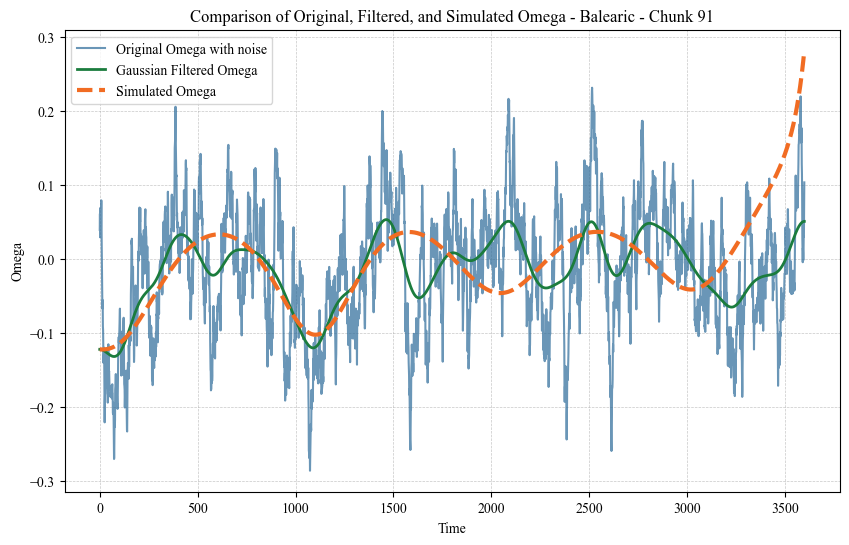

In [52]:
n=90
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = balearic_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = balearic_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original, omega_filtered)


## Model 2 case C

In [53]:
# for 'Balearic' region with noise
omega_Bal_time_filtered = apply_gaussian_filter(omega_Bal_time, sigma=60)
balearic_data = [chunk for chunk in omega_Bal_time_filtered if chunk['Region'].iloc[0] == 'balearic']
time_models = calculate_sindy_models_abs(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = -0.0001442 1 + -0.0000160 theta + 1.0004260 omega + -0.0000004 time + 0.0000001 theta^2 + -0.0000199 theta omega + 0.0255486 omega^2 + -0.0000007 omega time
(omega)' = -0.0002823 1 + -0.0000319 theta + 0.0009815 omega + -0.0000008 time + 0.0000001 theta^2 + -0.0000390 theta omega + 0.0512772 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4134749570678428

Model for Balearic - Chunk 2:
(theta)' = -0.0006846 1 + -0.0000211 theta + 0.9943795 omega + -0.0001111 theta omega + -0.0056225 omega^2 + 0.0000009 omega time
(omega)' = -0.0013571 1 + -0.0000422 theta + -0.0110766 omega + -0.0000001 time + -0.0002214 theta omega + -0.0111394 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.42803053274332575

Model for Balearic - Chunk 3:
(theta)' = -0.0003820 1 + -0.0000026 theta + 0.9995087 omega + 0.0000001 time + 0.0000002 theta^2 + 0.0000309 theta omega + 0.0034634 omega^2 + 0.0000008 omega time
(omega)' = -0.00022

Model for Balearic - Chunk 39:
(theta)' = -0.0000106 1 + -0.0000125 theta + 1.0002122 omega + -0.0000001 time + -0.0000003 theta^2 + -0.0000135 theta omega + -0.0006296 omega^2 + -0.0000003 omega time
(omega)' = -0.0000208 1 + -0.0000250 theta + 0.0004637 omega + -0.0000002 time + -0.0000007 theta^2 + -0.0000256 theta omega + -0.0012662 omega^2 + -0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.45361589630759536

Model for Balearic - Chunk 40:
(theta)' = -0.0002706 1 + -0.0000106 theta + 0.9977264 omega + 0.0000001 theta^2 + -0.0000542 theta omega + 0.0010006 omega^2 + 0.0000009 omega time
(omega)' = -0.0006796 1 + -0.0000234 theta + -0.0057558 omega + 0.0000002 time + 0.0000002 theta^2 + -0.0001462 theta omega + -0.0009464 omega^2 + 0.0000021 omega time
(time)' = 1.0000000 1
Model Score: 0.437186975655226

Model for Balearic - Chunk 41:
(theta)' = 0.0000162 1 + -0.0000291 theta + 1.0013620 omega + -0.0000008 time + -0.0000003 theta^2 + 0.0000374 theta omega + -0.0087432 omeg

Model for Balearic - Chunk 77:
(theta)' = -0.0002144 1 + -0.0000216 theta + 0.9975220 omega + -0.0000017 time + -0.0000001 theta^2 + -0.0000094 theta omega + -0.0058640 omega^2 + 0.0000011 omega time
(omega)' = -0.0004082 1 + -0.0000433 theta + -0.0046728 omega + -0.0000035 time + -0.0000002 theta^2 + -0.0000185 theta omega + -0.0111851 omega^2 + 0.0000020 omega time
(time)' = 1.0000000 1
Model Score: 0.4148618840377833

Model for Balearic - Chunk 78:
(theta)' = 0.0002457 1 + 0.0000099 theta + 1.0043462 omega + -0.0000012 time + 0.0000002 theta^2 + 0.0001028 theta omega + 0.0140971 omega^2 + 0.0000003 omega time
(omega)' = 0.0005344 1 + 0.0000204 theta + 0.0090076 omega + -0.0000024 time + 0.0000004 theta^2 + 0.0002090 theta omega + 0.0284841 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.45689854956230236

Model for Balearic - Chunk 79:
(theta)' = 0.0003280 1 + -0.0000558 theta + 0.9973683 omega + -0.0000007 time + 0.0000006 theta^2 + 0.0002784 theta omega + 0.000

Model Score: 0.4664767891149248

Model for Balearic - Chunk 115:
(theta)' = 0.0007257 1 + -0.0001472 theta + 0.9990392 omega + -0.0000018 time + 0.0000020 theta^2 + 0.0001209 theta omega + 0.0000001 theta time + -0.0201475 omega^2 + 0.0000014 omega time
(omega)' = 0.0014512 1 + -0.0002945 theta + -0.0017715 omega + -0.0000036 time + 0.0000040 theta^2 + 0.0002389 theta omega + 0.0000002 theta time + -0.0406218 omega^2 + 0.0000028 omega time
(time)' = 1.0000000 1
Model Score: 0.5226199711491523

Model for Balearic - Chunk 116:
(theta)' = 0.0001902 1 + -0.0000764 theta + 0.9988005 omega + 0.0000018 time + 0.0000011 theta^2 + 0.0000244 theta omega + 0.0225997 omega^2 + 0.0000003 omega time
(omega)' = 0.0003743 1 + -0.0001530 theta + -0.0022214 omega + 0.0000035 time + 0.0000021 theta^2 + 0.0000456 theta omega + 0.0454466 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.49584443631960157

Model for Balearic - Chunk 117:
(theta)' = -0.0006125 1 + 0.0000255 theta + 1.002132

Model for Balearic - Chunk 152:
(theta)' = 0.0001390 1 + -0.0000354 theta + 1.0013329 omega + 0.0000013 time + 0.0000003 theta^2 + -0.0000611 theta omega + 0.0180916 omega^2 + 0.0000005 omega time
(omega)' = 0.0002683 1 + -0.0000706 theta + 0.0027522 omega + 0.0000026 time + 0.0000006 theta^2 + -0.0001230 theta omega + 0.0362030 omega^2 + 0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.5187146115042024

Model for Balearic - Chunk 153:
(theta)' = -0.0000387 1 + -0.0000204 theta + 0.9981097 omega + 0.0000014 time + 0.0000002 theta^2 + 0.0000025 theta omega + 0.0244592 omega^2 + 0.0000006 omega time
(omega)' = -0.0000832 1 + -0.0000407 theta + -0.0037046 omega + 0.0000027 time + 0.0000005 theta^2 + 0.0000040 theta omega + 0.0488987 omega^2 + 0.0000013 omega time
(time)' = 1.0000000 1
Model Score: 0.4547572967091993

Model for Balearic - Chunk 154:
(theta)' = 0.0001639 1 + -0.0000191 theta + 0.9980795 omega + 0.0000005 time + 0.0000001 theta^2 + 0.0000670 theta omega + -0.0018045

Model for Balearic - Chunk 193:
(theta)' = -0.0001150 1 + 0.0000023 theta + 0.9994968 omega + 0.0000005 theta^2 + 0.0000044 theta omega + -0.0069139 omega^2 + 0.0000001 omega time
(omega)' = -0.0002278 1 + 0.0000048 theta + -0.0009626 omega + 0.0000010 theta^2 + 0.0000073 theta omega + -0.0000001 theta time + -0.0136640 omega^2 + 0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.4777766579514622

Model for Balearic - Chunk 194:
(theta)' = -0.0002504 1 + -0.0000256 theta + 0.9988708 omega + -0.0000007 time + -0.0000003 theta^2 + 0.0000112 theta omega + -0.0017358 omega^2 + 0.0000007 omega time
(omega)' = -0.0004860 1 + -0.0000507 theta + -0.0020562 omega + -0.0000014 time + -0.0000005 theta^2 + 0.0000250 theta omega + -0.0035202 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4131877643958033

Model for Balearic - Chunk 195:
(theta)' = -0.0002589 1 + -0.0000105 theta + 0.9971111 omega + -0.0000875 theta omega + 0.0056652 omega^2 + 0.0000005 omega time
(omega)

Model for Balearic - Chunk 213:
(theta)' = 0.0000783 1 + -0.0000110 theta + 1.0011716 omega + 0.0000005 time + 0.0000002 theta^2 + -0.0000422 theta omega + -0.0101916 omega^2 + -0.0000006 omega time
(omega)' = 0.0001473 1 + -0.0000222 theta + 0.0023742 omega + 0.0000009 time + 0.0000004 theta^2 + -0.0000833 theta omega + -0.0198447 omega^2 + -0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.40304449377907053

Model for Balearic - Chunk 214:
(theta)' = -0.0008877 1 + 0.0000234 theta + 1.0081524 omega + 0.0000011 time + -0.0000002 theta^2 + -0.0001220 theta omega + -0.0157389 omega^2 + -0.0000025 omega time
(omega)' = -0.0017694 1 + 0.0000462 theta + 0.0162395 omega + 0.0000022 time + -0.0000004 theta^2 + -0.0002416 theta omega + -0.0311126 omega^2 + -0.0000049 omega time
(time)' = 1.0000000 1
Model Score: 0.3924627838183145

Model for Balearic - Chunk 215:
(theta)' = 0.0002085 1 + -0.0000066 theta + 0.9970539 omega + 0.0000321 theta omega + 0.0119809 omega^2 + 0.0000011 omega t

Model Score: 0.47276920254955623

Model for Balearic - Chunk 251:
(theta)' = -0.0000423 1 + -0.0000071 theta + 0.9982331 omega + 0.0000010 time + -0.0000083 theta omega + 0.0160376 omega^2 + 0.0000010 omega time
(omega)' = -0.0001009 1 + -0.0000143 theta + -0.0033151 omega + 0.0000019 time + -0.0000181 theta omega + 0.0322966 omega^2 + 0.0000020 omega time
(time)' = 1.0000000 1
Model Score: 0.43887789228690394

Model for Balearic - Chunk 252:
(theta)' = 0.0003429 1 + 0.0000082 theta + 0.9999833 omega + -0.0000001 time + -0.0000006 theta^2 + -0.0000418 theta omega + -0.0151107 omega^2 + 0.0000002 omega time
(omega)' = 0.0006984 1 + 0.0000178 theta + -0.0000654 omega + -0.0000002 time + -0.0000013 theta^2 + -0.0000830 theta omega + -0.0308289 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.4369736284372688

Model for Balearic - Chunk 253:
(theta)' = 0.0005339 1 + 0.0000316 theta + 1.0053619 omega + -0.0000013 time + 0.0000003 theta^2 + 0.0001203 theta omega + 0.023524

Model Score: 0.4308692385106067

Model for Balearic - Chunk 290:
(theta)' = -0.0001791 1 + 0.0000040 theta + 0.9994282 omega + -0.0000005 time + 0.0000004 theta^2 + -0.0000171 theta omega + 0.0090765 omega^2 + -0.0000001 omega time
(omega)' = -0.0003546 1 + 0.0000079 theta + -0.0010916 omega + -0.0000011 time + 0.0000008 theta^2 + -0.0000361 theta omega + 0.0184842 omega^2 + -0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.47304456223026065

Model for Balearic - Chunk 291:
(theta)' = -0.0004820 1 + 0.0000235 theta + 0.9965339 omega + 0.0000003 time + 0.0000004 theta^2 + 0.0000169 theta omega + 0.0170073 omega^2 + 0.0000013 omega time
(omega)' = -0.0003805 1 + 0.0000454 theta + -0.0016634 omega + 0.0000006 theta^2 + 0.0000857 theta omega + 0.0302552 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.4012364583445329

Model for Balearic - Chunk 292:
(theta)' = -0.0005582 1 + -0.0000184 theta + 0.9974350 omega + -0.0000002 theta^2 + -0.0000134 theta omega + 0.02

Model for Balearic - Chunk 328:
(theta)' = -0.0000292 1 + 0.0000001 theta + 0.9999871 omega + -0.0000002 time + 0.0000001 theta^2 + 0.0000059 theta omega + 0.0045552 omega^2
(omega)' = -0.0000557 1 + -0.0000002 theta + 0.0000242 omega + -0.0000005 time + 0.0000002 theta^2 + 0.0000101 theta omega + 0.0090831 omega^2
(time)' = 1.0000000 1
Model Score: 0.3714282584690783

Model for Balearic - Chunk 329:
(theta)' = -0.0003658 1 + -0.0000170 theta + 0.9992785 omega + -0.0000001 time + 0.0000001 theta^2 + 0.0000003 theta omega + 0.0236623 omega^2 + 0.0000006 omega time
(omega)' = -0.0007222 1 + -0.0000335 theta + -0.0013224 omega + -0.0000003 time + 0.0000003 theta^2 + -0.0000020 theta omega + 0.0474708 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4270638921161392

Model for Balearic - Chunk 330:
(theta)' = -0.0002305 1 + 0.0000021 theta + 0.9974364 omega + -0.0000004 time + 0.0000001 theta^2 + -0.0000168 theta omega + 0.0041347 omega^2 + 0.0000008 omega time
(omega)' 

Model for Balearic - Chunk 365:
(theta)' = 0.0003432 1 + 0.0000156 theta + 1.0072166 omega + -0.0000006 time + 0.0000002 theta^2 + 0.0001768 theta omega + 0.0214211 omega^2 + -0.0000026 omega time
(omega)' = 0.0006953 1 + 0.0000314 theta + 0.0146366 omega + -0.0000013 time + 0.0000004 theta^2 + 0.0003551 theta omega + 0.0435698 omega^2 + -0.0000053 omega time
(time)' = 1.0000000 1
Model Score: 0.4082998437502809

Model for Balearic - Chunk 366:
(theta)' = 0.0009320 1 + 0.0000154 theta + 1.0029273 omega + -0.0000017 time + 0.0000001 theta^2 + 0.0000636 theta omega + -0.0070405 omega^2 + 0.0000001 omega time
(omega)' = 0.0018852 1 + 0.0000311 theta + 0.0059726 omega + -0.0000034 time + 0.0000002 theta^2 + 0.0001277 theta omega + -0.0141703 omega^2 + 0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.4051435072986009

Model for Balearic - Chunk 367:
(theta)' = 0.0000136 1 + -0.0000095 theta + 1.0000327 omega + 0.0000002 time + -0.0000001 theta^2 + -0.0000149 theta omega + 0.0011941

Model Score: 0.45282303720533396

Model for Balearic - Chunk 405:
(theta)' = -0.0001265 1 + -0.0000139 theta + 0.9990770 omega + 0.0000010 time + 0.0000001 theta^2 + -0.0000271 theta omega + 0.0068035 omega^2 + 0.0000009 omega time
(omega)' = -0.0002542 1 + -0.0000283 theta + -0.0017477 omega + 0.0000020 time + 0.0000003 theta^2 + -0.0000548 theta omega + 0.0135619 omega^2 + 0.0000019 omega time
(time)' = 1.0000000 1
Model Score: 0.39318009963829553

Model for Balearic - Chunk 406:
(theta)' = 0.0002145 1 + 0.0000218 theta + 0.9944244 omega + -0.0000001 time + -0.0000005 theta^2 + 0.0000750 theta omega + -0.0086243 omega^2 + 0.0000020 omega time
(omega)' = 0.0004171 1 + 0.0000433 theta + -0.0108985 omega + -0.0000002 time + -0.0000010 theta^2 + 0.0001467 theta omega + -0.0170517 omega^2 + 0.0000040 omega time
(time)' = 1.0000000 1
Model Score: 0.4168549932701852

Model for Balearic - Chunk 407:
(theta)' = 0.0001381 1 + -0.0000305 theta + 1.0001639 omega + 0.0000012 time + 0.0000003 thet

Model Score: 0.44454507196221477

Model for Balearic - Chunk 444:
(theta)' = -0.0000382 1 + 0.0000078 theta + 1.0000605 omega + 0.0000004 time + -0.0000002 theta^2 + 0.0017825 omega^2 + -0.0000002 omega time
(omega)' = -0.0000787 1 + 0.0000158 theta + 0.0001461 omega + 0.0000007 time + -0.0000005 theta^2 + -0.0000002 theta omega + 0.0033551 omega^2 + -0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.42605196077171964

Model for Balearic - Chunk 445:
(theta)' = 0.0000934 1 + -0.0000268 theta + 1.0004494 omega + -0.0000005 time + 0.0000001 theta^2 + 0.0000095 theta omega + -0.0010776 omega^2 + -0.0000002 omega time
(omega)' = 0.0001875 1 + -0.0000538 theta + 0.0010643 omega + -0.0000011 time + 0.0000002 theta^2 + 0.0000202 theta omega + -0.0022968 omega^2 + -0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.4821787920307257

Model for Balearic - Chunk 446:
(theta)' = -0.0006419 1 + -0.0000112 theta + 0.9957366 omega + -0.0000007 time + 0.0000001 theta^2 + -0.0000584 thet

Model for Balearic - Chunk 464:
(theta)' = 0.0001960 1 + -0.0000305 theta + 0.9995532 omega + 0.0000027 time + 0.0000001 theta^2 + 0.0000152 theta omega + -0.0038293 omega^2 + -0.0000002 omega time
(omega)' = 0.0003762 1 + -0.0000612 theta + -0.0007512 omega + 0.0000054 time + 0.0000003 theta^2 + 0.0000298 theta omega + -0.0075855 omega^2 + -0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.420790047387752

Model for Balearic - Chunk 465:
(theta)' = 0.0004904 1 + -0.0000231 theta + 1.0004943 omega + 0.0000007 time + 0.0000002 theta^2 + -0.0000409 theta omega + -0.0070111 omega^2 + 0.0000001 omega time
(omega)' = 0.0009700 1 + -0.0000464 theta + 0.0010862 omega + 0.0000013 time + 0.0000004 theta^2 + -0.0000814 theta omega + -0.0139555 omega^2 + 0.0000002 omega time
(time)' = 1.0000000 1
Model Score: 0.49363745855768154

Model for Balearic - Chunk 466:
(theta)' = -0.0002468 1 + 0.0000294 theta + 1.0018738 omega + 0.0000001 time + -0.0000008 theta^2 + -0.0001206 theta omega + -0.0

Model Score: 0.4780187868265209

Model for Balearic - Chunk 485:
(theta)' = -0.0002372 1 + -0.0000061 theta + 1.0028532 omega + -0.0000004 time + 0.0000601 theta omega + 0.0177070 omega^2 + -0.0000011 omega time
(omega)' = -0.0004401 1 + -0.0000115 theta + 0.0059807 omega + -0.0000009 time + 0.0001227 theta omega + 0.0358770 omega^2 + -0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.42830976374652346

Model for Balearic - Chunk 486:
(theta)' = -0.0002603 1 + -0.0000004 theta + 0.9961604 omega + -0.0000001 time + 0.0000002 theta^2 + -0.0000653 theta omega + 0.0040693 omega^2 + 0.0000011 omega time
(omega)' = -0.0007286 1 + -0.0000022 theta + -0.0115698 omega + 0.0000001 time + 0.0000004 theta^2 + -0.0001675 theta omega + -0.0036950 omega^2 + 0.0000037 omega time
(time)' = 1.0000000 1
Model Score: 0.39634818919343956

Model for Balearic - Chunk 487:
(theta)' = 0.0001721 1 + -0.0000270 theta + 0.9962853 omega + -0.0000002 time + 0.0000002 theta^2 + 0.0001372 theta omega + 0.0260

Model for Balearic - Chunk 523:
(theta)' = -0.0000354 1 + -0.0000283 theta + 0.9977370 omega + -0.0000006 theta^2 + 0.0001082 theta omega + 0.0125815 omega^2 + 0.0000034 omega time
(omega)' = -0.0000690 1 + -0.0000573 theta + -0.0044062 omega + 0.0000001 time + -0.0000011 theta^2 + 0.0002167 theta omega + 0.0250401 omega^2 + 0.0000067 omega time
(time)' = 1.0000000 1
Model Score: 0.44706619258791785

Model for Balearic - Chunk 524:
(theta)' = 0.0004040 1 + -0.0000374 theta + 0.9993779 omega + 0.0000004 time + 0.0000003 theta^2 + -0.0000117 theta omega + 0.0098652 omega^2 + 0.0000003 omega time
(omega)' = 0.0008062 1 + -0.0000745 theta + -0.0012665 omega + 0.0000009 time + 0.0000007 theta^2 + -0.0000222 theta omega + 0.0197950 omega^2 + 0.0000007 omega time
(time)' = 1.0000000 1
Model Score: 0.4668560120088519

Model for Balearic - Chunk 525:
(theta)' = -0.0004898 1 + -0.0000026 theta + 1.0068134 omega + 0.0000013 time + 0.0000001 theta^2 + -0.0000650 theta omega + -0.0224854 omega^2 + 

Model Score: 0.5091954051989682

Model for Balearic - Chunk 563:
(theta)' = 0.0001383 1 + -0.0000338 theta + 0.9992319 omega + 0.0000011 time + 0.0000003 theta^2 + -0.0000122 theta omega + 0.0128958 omega^2 + 0.0000007 omega time
(omega)' = 0.0002756 1 + -0.0000674 theta + -0.0014562 omega + 0.0000022 time + 0.0000006 theta^2 + -0.0000248 theta omega + 0.0249155 omega^2 + 0.0000015 omega time
(time)' = 1.0000000 1
Model Score: 0.46662464835516576

Model for Balearic - Chunk 564:
(theta)' = 0.0000832 1 + -0.0000290 theta + 1.0020423 omega + 0.0000015 time + 0.0000002 theta^2 + -0.0000073 theta omega + -0.0108980 omega^2 + -0.0000008 omega time
(omega)' = 0.0001628 1 + -0.0000583 theta + 0.0041496 omega + 0.0000030 time + 0.0000004 theta^2 + -0.0000137 theta omega + -0.0215182 omega^2 + -0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.42729003077730104

Model for Balearic - Chunk 565:
(theta)' = 0.0003262 1 + -0.0000180 theta + 0.9985136 omega + -0.0000002 time + -0.0000005 the

Model for Balearic - Chunk 600:
(theta)' = 0.0000877 1 + -0.0000048 theta + 0.9949533 omega + 0.0000006 time + -0.0000006 theta^2 + 0.0001052 theta omega + 0.0543135 omega^2 + 0.0000032 omega time
(omega)' = 0.0001735 1 + -0.0000096 theta + -0.0100327 omega + 0.0000012 time + -0.0000012 theta^2 + 0.0002110 theta omega + 0.1085720 omega^2 + 0.0000064 omega time
(time)' = 1.0000000 1
Model Score: 0.5465463084236101

Model for Balearic - Chunk 601:
(theta)' = -0.0000835 1 + -0.0000131 theta + 1.0007543 omega + 0.0000004 time + 0.0000002 theta^2 + 0.0000891 theta omega + 0.0040139 omega^2 + -0.0000023 omega time
(omega)' = -0.0001678 1 + -0.0000260 theta + 0.0015224 omega + 0.0000008 time + 0.0000004 theta^2 + 0.0001773 theta omega + 0.0083937 omega^2 + -0.0000046 omega time
(time)' = 1.0000000 1
Model Score: 0.47967278765190313

Model for Balearic - Chunk 602:
(theta)' = -0.0000051 1 + -0.0000011 theta + 1.0021861 omega + -0.0000003 time + 0.0000002 theta^2 + 0.0000573 theta omega + 0.010

Model Score: 0.5010518640438651

Model for Balearic - Chunk 640:
(theta)' = -0.0000141 1 + -0.0000361 theta + 0.9930787 omega + -0.0000027 time + -0.0000002 theta^2 + -0.0000211 theta omega + -0.0330535 omega^2 + 0.0000040 omega time
(omega)' = -0.0000243 1 + -0.0000726 theta + -0.0137680 omega + -0.0000054 time + -0.0000004 theta^2 + -0.0000425 theta omega + -0.0661993 omega^2 + 0.0000079 omega time
(time)' = 1.0000000 1
Model Score: 0.4807346370278913

Model for Balearic - Chunk 641:
(theta)' = -0.0000081 1 + -0.0000091 theta + 0.9969854 omega + -0.0000015 time + 0.0000002 theta^2 + -0.0000199 theta omega + -0.0069920 omega^2 + 0.0000012 omega time
(omega)' = 0.0000175 1 + -0.0000172 theta + -0.0058227 omega + -0.0000030 time + 0.0000003 theta^2 + -0.0000382 theta omega + -0.0138959 omega^2 + 0.0000024 omega time
(time)' = 1.0000000 1
Model Score: 0.4742057751485856

Model for Balearic - Chunk 642:
(theta)' = -0.0002959 1 + -0.0000594 theta + 0.9983233 omega + -0.0000014 time + -0.00

Model for Balearic - Chunk 678:
(theta)' = -0.0000699 1 + -0.0000173 theta + 0.9968082 omega + -0.0000005 time + -0.0000003 theta^2 + -0.0000309 theta omega + -0.0187804 omega^2 + 0.0000013 omega time
(omega)' = -0.0001351 1 + -0.0000347 theta + -0.0061937 omega + -0.0000011 time + -0.0000006 theta^2 + -0.0000606 theta omega + -0.0373241 omega^2 + 0.0000026 omega time
(time)' = 1.0000000 1
Model Score: 0.4038368834350812

Model for Balearic - Chunk 679:
(theta)' = -0.0001077 1 + -0.0000051 theta + 0.9985824 omega + 0.0000004 time + 0.0000001 theta^2 + 0.0000529 theta omega + 0.0023014 omega^2 + 0.0000013 omega time
(omega)' = -0.0002146 1 + -0.0000105 theta + -0.0027810 omega + 0.0000007 time + 0.0000001 theta^2 + 0.0001069 theta omega + 0.0045789 omega^2 + 0.0000027 omega time
(time)' = 1.0000000 1
Model Score: 0.46108777268976914

Model for Balearic - Chunk 680:
(theta)' = -0.0013149 1 + 0.0000519 theta + 1.0015059 omega + 0.0000014 time + -0.0000005 theta^2 + -0.0000740 theta omega 

Model for Balearic - Chunk 698:
(theta)' = -0.0000703 1 + -0.0000266 theta + 0.9991519 omega + -0.0000013 time + -0.0000002 theta^2 + -0.0000216 theta omega + -0.0083804 omega^2 + 0.0000001 omega time
(omega)' = -0.0001335 1 + -0.0000533 theta + -0.0015746 omega + -0.0000027 time + -0.0000004 theta^2 + -0.0000421 theta omega + -0.0166966 omega^2 + 0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.4491701371943823

Model for Balearic - Chunk 699:
(theta)' = 0.0003714 1 + -0.0000042 theta + 1.0029217 omega + -0.0000020 time + 0.0000002 theta^2 + 0.0000662 theta omega + -0.0020672 omega^2
(omega)' = 0.0007432 1 + -0.0000085 theta + 0.0057733 omega + -0.0000039 time + 0.0000004 theta^2 + 0.0001303 theta omega + -0.0048779 omega^2 + 0.0000001 omega time
(time)' = 1.0000000 1
Model Score: 0.4625977543668167

Model for Balearic - Chunk 700:
(theta)' = -0.0000719 1 + -0.0000156 theta + 0.9972306 omega + -0.0000010 time + 0.0000001 theta^2 + -0.0000351 theta omega + -0.0174558 omega^2 +

Model for Balearic - Chunk 718:
(theta)' = 0.0003147 1 + -0.0000062 theta + 0.9989084 omega + 0.0000003 time + -0.0000003 theta^2 + 0.0000537 theta omega + -0.0194412 omega^2 + -0.0000003 omega time
(omega)' = 0.0006082 1 + -0.0000117 theta + -0.0020615 omega + 0.0000006 time + -0.0000006 theta^2 + 0.0001074 theta omega + -0.0386905 omega^2 + -0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.4146227578586796

Model for Balearic - Chunk 719:
(theta)' = 0.0003962 1 + -0.0000291 theta + 0.9961427 omega + 0.0000005 time + 0.0000981 theta omega + 0.0060021 omega^2 + 0.0000013 omega time
(omega)' = 0.0007843 1 + -0.0000580 theta + -0.0076867 omega + 0.0000010 time + 0.0001975 theta omega + 0.0124925 omega^2 + 0.0000026 omega time
(time)' = 1.0000000 1
Model Score: 0.43795242977769133

Model for Balearic - Chunk 720:
(theta)' = -0.0002706 1 + 0.0000083 theta + 0.9992792 omega + 0.0000008 time + -0.0000003 theta^2 + -0.0000394 theta omega + 0.0342705 omega^2 + 0.0000013 omega time
(om

In [54]:
balearic_models = calculate_sindy_models(balearic_data, 'Balearic')

Model for Balearic - Chunk 1:
(theta)' = -0.0001442 1 + -0.0000160 theta + 1.0004260 omega + -0.0000004 time + 0.0000001 theta^2 + -0.0000199 theta omega + 0.0255486 omega^2 + -0.0000007 omega time
(omega)' = -0.0002823 1 + -0.0000319 theta + 0.0009815 omega + -0.0000008 time + 0.0000001 theta^2 + -0.0000390 theta omega + 0.0512772 omega^2 + -0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4134749570678428

Model for Balearic - Chunk 2:
(theta)' = -0.0006846 1 + -0.0000211 theta + 0.9943795 omega + -0.0001111 theta omega + -0.0056225 omega^2 + 0.0000009 omega time
(omega)' = -0.0013571 1 + -0.0000422 theta + -0.0110766 omega + -0.0000001 time + -0.0002214 theta omega + -0.0111394 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.42803053274332575

Model for Balearic - Chunk 3:
(theta)' = -0.0003820 1 + -0.0000026 theta + 0.9995087 omega + 0.0000001 time + 0.0000002 theta^2 + 0.0000309 theta omega + 0.0034634 omega^2 + 0.0000008 omega time
(omega)' = -0.00022

Model for Balearic - Chunk 38:
(theta)' = -0.0000594 1 + 0.0000227 theta + 0.9939958 omega + -0.0000005 time + 0.0000006 theta^2 + -0.0001111 theta omega + 0.0032579 omega^2 + 0.0000015 omega time
(omega)' = -0.0001207 1 + 0.0000446 theta + -0.0120252 omega + -0.0000010 time + 0.0000011 theta^2 + -0.0002247 theta omega + 0.0061703 omega^2 + 0.0000030 omega time
(time)' = 1.0000000 1
Model Score: 0.4654719647879251

Model for Balearic - Chunk 39:
(theta)' = -0.0000106 1 + -0.0000125 theta + 1.0002122 omega + -0.0000001 time + -0.0000003 theta^2 + -0.0000135 theta omega + -0.0006296 omega^2 + -0.0000003 omega time
(omega)' = -0.0000208 1 + -0.0000250 theta + 0.0004637 omega + -0.0000002 time + -0.0000007 theta^2 + -0.0000256 theta omega + -0.0012662 omega^2 + -0.0000006 omega time
(time)' = 1.0000000 1
Model Score: 0.45361589630759536

Model for Balearic - Chunk 40:
(theta)' = -0.0002706 1 + -0.0000106 theta + 0.9977264 omega + 0.0000001 theta^2 + -0.0000542 theta omega + 0.0010006 omega

Model Score: 0.45689854956230236

Model for Balearic - Chunk 79:
(theta)' = 0.0003280 1 + -0.0000558 theta + 0.9973683 omega + -0.0000007 time + 0.0000006 theta^2 + 0.0002784 theta omega + 0.0006378 omega^2 + 0.0000036 omega time
(omega)' = 0.0006556 1 + -0.0001118 theta + -0.0052223 omega + -0.0000014 time + 0.0000012 theta^2 + 0.0005608 theta omega + 0.0000001 theta time + 0.0012198 omega^2 + 0.0000072 omega time
(time)' = 1.0000000 1
Model Score: 0.4696468680769364

Model for Balearic - Chunk 80:
(theta)' = 0.0000817 1 + -0.0000038 theta + 1.0016627 omega + 0.0000004 time + -0.0000004 theta^2 + -0.0001022 theta omega + 0.0056307 omega^2 + -0.0000010 omega time
(omega)' = 0.0001576 1 + -0.0000074 theta + 0.0033897 omega + 0.0000007 time + -0.0000007 theta^2 + -0.0002033 theta omega + 0.0111334 omega^2 + -0.0000021 omega time
(time)' = 1.0000000 1
Model Score: 0.45486322960256026

Model for Balearic - Chunk 81:
(theta)' = 0.0005784 1 + 0.0000301 theta + 0.9959253 omega + -0.0000004 ti

Model for Balearic - Chunk 116:
(theta)' = 0.0001902 1 + -0.0000764 theta + 0.9988005 omega + 0.0000018 time + 0.0000011 theta^2 + 0.0000244 theta omega + 0.0225997 omega^2 + 0.0000003 omega time
(omega)' = 0.0003743 1 + -0.0001530 theta + -0.0022214 omega + 0.0000035 time + 0.0000021 theta^2 + 0.0000456 theta omega + 0.0454466 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.49584443631960157

Model for Balearic - Chunk 117:
(theta)' = -0.0006125 1 + 0.0000255 theta + 1.0021326 omega + 0.0000011 time + -0.0000003 theta^2 + -0.0000618 theta omega + 0.0093491 omega^2 + -0.0000005 omega time
(omega)' = -0.0012318 1 + 0.0000509 theta + 0.0043981 omega + 0.0000022 time + -0.0000006 theta^2 + -0.0001245 theta omega + 0.0183573 omega^2 + -0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.46795747226201617

Model for Balearic - Chunk 118:
(theta)' = 0.0001243 1 + 0.0000083 theta + 0.9940247 omega + 0.0000003 time + -0.0000003 theta^2 + 0.0000952 theta omega + 0.0156

Model for Balearic - Chunk 136:
(theta)' = -0.0003499 1 + -0.0000173 theta + 1.0021732 omega + -0.0000002 time + -0.0000002 theta^2 + 0.0000992 theta omega + 0.0084408 omega^2 + 0.0000003 omega time
(omega)' = -0.0008000 1 + -0.0000317 theta + 0.0032533 omega + -0.0000001 time + -0.0000004 theta^2 + 0.0002255 theta omega + 0.0132259 omega^2 + 0.0000014 omega time
(time)' = 1.0000000 1
Model Score: 0.4260980101905898

Model for Balearic - Chunk 137:
(theta)' = 0.0001249 1 + -0.0000236 theta + 0.9992805 omega + -0.0000021 time + -0.0000003 theta^2 + 0.0000242 theta omega + -0.0172026 omega^2 + 0.0000009 omega time
(omega)' = 0.0002773 1 + -0.0000465 theta + -0.0011812 omega + -0.0000042 time + -0.0000006 theta^2 + 0.0000511 theta omega + -0.0338384 omega^2 + 0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.45911803416372665

Model for Balearic - Chunk 138:
(theta)' = 0.0001117 1 + 0.0000023 theta + 1.0043233 omega + -0.0000006 time + -0.0000003 theta^2 + 0.0001870 theta omega + 

Model Score: 0.42040941365989176

Model for Balearic - Chunk 177:
(theta)' = 0.0001296 1 + 0.0000051 theta + 1.0032752 omega + 0.0000004 time + -0.0000001 theta^2 + -0.0000801 theta omega + -0.0159225 omega^2 + -0.0000006 omega time
(omega)' = 0.0002548 1 + 0.0000100 theta + 0.0065829 omega + 0.0000008 time + -0.0000003 theta^2 + -0.0001592 theta omega + -0.0317386 omega^2 + -0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.4171842968426069

Model for Balearic - Chunk 178:
(theta)' = 0.0001389 1 + 0.0000022 theta + 0.9962571 omega + 0.0000002 time + -0.0000002 theta^2 + 0.0000384 theta omega + -0.0010447 omega^2 + 0.0000018 omega time
(omega)' = 0.0002748 1 + 0.0000042 theta + -0.0074177 omega + 0.0000005 time + -0.0000004 theta^2 + 0.0000765 theta omega + -0.0022147 omega^2 + 0.0000036 omega time
(time)' = 1.0000000 1
Model Score: 0.38677904397470053

Model for Balearic - Chunk 179:
(theta)' = -0.0003882 1 + 0.0000145 theta + 1.0007575 omega + 0.0000007 time + -0.0000003 thet

Model for Balearic - Chunk 215:
(theta)' = 0.0002085 1 + -0.0000066 theta + 0.9970539 omega + 0.0000321 theta omega + 0.0119809 omega^2 + 0.0000011 omega time
(omega)' = 0.0003840 1 + -0.0000876 theta + -0.0033931 omega + 0.0000026 time + 0.0000004 theta^2 + 0.0000676 theta omega + 0.0312213 omega^2 + 0.0000007 omega time
(time)' = 1.0000000 1
Model Score: 0.4666176574722747

Model for Balearic - Chunk 216:
(theta)' = 0.0000357 1 + -0.0000158 theta + 1.0032407 omega + 0.0000006 time + -0.0000002 theta^2 + -0.0001446 theta omega + -0.0073126 omega^2 + -0.0000009 omega time
(omega)' = 0.0000681 1 + -0.0000313 theta + 0.0066024 omega + 0.0000012 time + -0.0000005 theta^2 + -0.0002907 theta omega + -0.0149818 omega^2 + -0.0000018 omega time
(time)' = 1.0000000 1
Model Score: 0.47191890615687077

Model for Balearic - Chunk 217:
(theta)' = 0.0000074 1 + 0.0000064 theta + 1.0011024 omega + -0.0000001 time + 0.0000001 theta^2 + 0.0000717 theta omega + -0.0209687 omega^2 + -0.0000014 omega time

Model Score: 0.42874786402347514

Model for Balearic - Chunk 254:
(theta)' = -0.0003580 1 + -0.0000320 theta + 0.9954923 omega + -0.0000016 time + -0.0000003 theta^2 + -0.0000185 theta omega + -0.0210357 omega^2 + 0.0000024 omega time
(omega)' = -0.0006888 1 + -0.0000634 theta + -0.0088378 omega + -0.0000033 time + -0.0000006 theta^2 + -0.0000356 theta omega + -0.0424364 omega^2 + 0.0000048 omega time
(time)' = 1.0000000 1
Model Score: 0.4530743225118837

Model for Balearic - Chunk 255:
(theta)' = -0.0011382 1 + -0.0000297 theta + 0.9836634 omega + -0.0000001 time + -0.0000001 theta^2 + -0.0001970 theta omega + -0.0342962 omega^2 + 0.0000054 omega time
(omega)' = -0.0022525 1 + -0.0000593 theta + -0.0324006 omega + -0.0000002 time + -0.0000002 theta^2 + -0.0003915 theta omega + -0.0687732 omega^2 + 0.0000108 omega time
(time)' = 1.0000000 1
Model Score: 0.460892178747023

Model for Balearic - Chunk 256:
(theta)' = -0.0003482 1 + -0.0000253 theta + 0.9873159 omega + -0.0000004 time + -0

Model for Balearic - Chunk 291:
(theta)' = -0.0004820 1 + 0.0000235 theta + 0.9965339 omega + 0.0000003 time + 0.0000004 theta^2 + 0.0000169 theta omega + 0.0170073 omega^2 + 0.0000013 omega time
(omega)' = -0.0003805 1 + 0.0000454 theta + -0.0016634 omega + 0.0000006 theta^2 + 0.0000857 theta omega + 0.0302552 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.4012364583445329

Model for Balearic - Chunk 292:
(theta)' = -0.0005582 1 + -0.0000184 theta + 0.9974350 omega + -0.0000002 theta^2 + -0.0000134 theta omega + 0.0271438 omega^2 + 0.0000005 omega time
(omega)' = -0.0011004 1 + -0.0000370 theta + -0.0049689 omega + -0.0000004 theta^2 + -0.0000246 theta omega + 0.0531282 omega^2 + 0.0000010 omega time
(time)' = 1.0000000 1
Model Score: 0.4387146105232653

Model for Balearic - Chunk 293:
(theta)' = 0.0001917 1 + -0.0000283 theta + 1.0044273 omega + -0.0000015 time + -0.0000005 theta^2 + 0.0001254 theta omega + -0.0000957 omega^2 + -0.0000011 omega time
(omega)' = 0.

Model for Balearic - Chunk 331:
(theta)' = 0.0001375 1 + -0.0000518 theta + 1.0013859 omega + -0.0000010 time + 0.0000007 theta^2 + 0.0000378 theta omega + 0.0285494 omega^2 + 0.0000004 omega time
(omega)' = 0.0002771 1 + -0.0001039 theta + 0.0029357 omega + -0.0000020 time + 0.0000015 theta^2 + 0.0000704 theta omega + 0.0000001 theta time + 0.0576292 omega^2 + 0.0000007 omega time
(time)' = 1.0000000 1
Model Score: 0.42439192181587054

Model for Balearic - Chunk 332:
(theta)' = 0.0003243 1 + -0.0000064 theta + 0.9972668 omega + 0.0000165 theta omega + 0.0052292 omega^2 + 0.0000010 omega time
(omega)' = 0.0008436 1 + -0.0000135 theta + -0.0074633 omega + -0.0000002 time + 0.0000502 theta omega + 0.0103213 omega^2 + 0.0000027 omega time
(time)' = 1.0000000 1
Model Score: 0.40635338708322716

Model for Balearic - Chunk 333:
(theta)' = 0.0003342 1 + -0.0000079 theta + 0.9959169 omega + -0.0000005 theta^2 + -0.0000356 theta omega + 0.0210596 omega^2 + 0.0000027 omega time
(omega)' = 0.0006

Model Score: 0.4299417947612529

Model for Balearic - Chunk 352:
(theta)' = -0.0005319 1 + -0.0000138 theta + 0.9965938 omega + -0.0000003 time + -0.0000240 theta omega + -0.0018709 omega^2 + 0.0000011 omega time
(omega)' = -0.0010505 1 + -0.0000277 theta + -0.0067162 omega + -0.0000007 time + -0.0000001 theta^2 + -0.0000477 theta omega + -0.0039087 omega^2 + 0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.3996150969041381

Model for Balearic - Chunk 353:
(theta)' = -0.0000876 1 + -0.0000416 theta + 0.9988876 omega + -0.0000016 time + -0.0000003 theta^2 + 0.0000099 theta omega + -0.0153766 omega^2 + 0.0000009 omega time
(omega)' = -0.0001709 1 + -0.0000833 theta + -0.0021280 omega + -0.0000031 time + -0.0000006 theta^2 + 0.0000195 theta omega + -0.0306865 omega^2 + 0.0000019 omega time
(time)' = 1.0000000 1
Model Score: 0.46072132840723246

Model for Balearic - Chunk 354:
(theta)' = -0.0001982 1 + 0.0000183 theta + 0.9988142 omega + 0.0000002 time + 0.0000004 theta^2 + 0.0000

Model for Balearic - Chunk 390:
(theta)' = -0.0001717 1 + -0.0000123 theta + 1.0001453 omega + -0.0000002 time + -0.0000001 theta^2 + 0.0000107 theta omega + 0.0109615 omega^2 + 0.0000004 omega time
(omega)' = -0.0003570 1 + -0.0001128 theta + 0.0037187 omega + -0.0000023 time + -0.0000011 theta^2 + 0.0000694 theta omega + 0.0211778 omega^2 + -0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.49602544512398355

Model for Balearic - Chunk 391:
(theta)' = -0.0000608 1 + 0.0000234 theta + 1.0002320 omega + 0.0000006 time + -0.0000009 theta^2 + -0.0000150 theta omega + -0.0034557 omega^2 + -0.0000005 omega time
(omega)' = -0.0001197 1 + 0.0000463 theta + 0.0004226 omega + 0.0000011 time + -0.0000018 theta^2 + -0.0000253 theta omega + -0.0000001 theta time + -0.0067943 omega^2 + -0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.4201915654234248

Model for Balearic - Chunk 392:
(theta)' = -0.0004645 1 + 0.0000209 theta + 1.0037388 omega + 0.0000009 time + -0.0000003 theta^2 

Model Score: 0.4251883482338132

Model for Balearic - Chunk 410:
(theta)' = -0.0004186 1 + -0.0000076 theta + 0.9983927 omega + -0.0000001 time + 0.0000003 theta^2 + 0.0000010 theta omega + -0.0045275 omega^2 + 0.0000006 omega time
(omega)' = -0.0008346 1 + -0.0000150 theta + -0.0032384 omega + -0.0000001 time + 0.0000007 theta^2 + -0.0000005 theta omega + -0.0090894 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.4538699855657904

Model for Balearic - Chunk 411:
(theta)' = -0.0001103 1 + -0.0000053 theta + 0.9965901 omega + -0.0000003 time + -0.0000092 theta omega + -0.0181612 omega^2 + 0.0000018 omega time
(omega)' = -0.0001994 1 + -0.0000096 theta + -0.0067129 omega + -0.0000007 time + 0.0000001 theta^2 + -0.0000174 theta omega + -0.0364134 omega^2 + 0.0000037 omega time
(time)' = 1.0000000 1
Model Score: 0.37822061288263614

Model for Balearic - Chunk 412:
(theta)' = -0.0014096 1 + -0.0000642 theta + 1.0019449 omega + -0.0000011 time + -0.0000004 theta^2 + -0.00

Model for Balearic - Chunk 430:
(theta)' = -0.0000884 1 + 0.0000006 theta + 1.0019576 omega + 0.0000009 time + -0.0000002 theta^2 + -0.0000214 theta omega + -0.0216179 omega^2 + -0.0000009 omega time
(omega)' = -0.0001813 1 + 0.0000009 theta + 0.0040186 omega + 0.0000018 time + -0.0000003 theta^2 + -0.0000427 theta omega + -0.0432416 omega^2 + -0.0000019 omega time
(time)' = 1.0000000 1
Model Score: 0.4803955449389014

Model for Balearic - Chunk 431:
(theta)' = -0.0002315 1 + 0.0000008 theta + 0.9992033 omega + 0.0000010 time + -0.0000001 theta^2 + 0.0000181 theta omega + 0.0058447 omega^2 + 0.0000002 omega time
(omega)' = -0.0004624 1 + 0.0000012 theta + -0.0015727 omega + 0.0000020 time + -0.0000002 theta^2 + 0.0000370 theta omega + 0.0118884 omega^2 + 0.0000005 omega time
(time)' = 1.0000000 1
Model Score: 0.47357732132941655

Model for Balearic - Chunk 432:
(theta)' = 0.0000122 1 + -0.0000072 theta + 0.9984186 omega + 0.0000013 time + -0.0000001 theta^2 + 0.0000029 theta omega + 0.

Model for Balearic - Chunk 469:
(theta)' = -0.0003535 1 + -0.0000164 theta + 0.9995680 omega + 0.0000001 time + 0.0000002 theta^2 + 0.0000498 theta omega + 0.0157398 omega^2 + -0.0000004 omega time
(omega)' = -0.0007021 1 + -0.0000324 theta + -0.0008108 omega + 0.0000003 time + 0.0000004 theta^2 + 0.0000996 theta omega + 0.0317989 omega^2 + -0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.47473234504437034

Model for Balearic - Chunk 470:
(theta)' = 0.0000768 1 + -0.0000091 theta + 1.0014874 omega + -0.0000009 time + 0.0000002 theta^2 + 0.0000473 theta omega + -0.0065150 omega^2 + 0.0000002 omega time
(omega)' = 0.0001615 1 + -0.0000182 theta + 0.0030928 omega + -0.0000019 time + 0.0000004 theta^2 + 0.0000960 theta omega + -0.0132265 omega^2 + 0.0000003 omega time
(time)' = 1.0000000 1
Model Score: 0.45309432465206667

Model for Balearic - Chunk 471:
(theta)' = -0.0001415 1 + -0.0000136 theta + 0.9983201 omega + -0.0000004 time + -0.0000001 theta^2 + -0.0000222 theta omega + 

Model for Balearic - Chunk 489:
(theta)' = 0.0001182 1 + 0.0000090 theta + 0.9972897 omega + -0.0000001 time + -0.0000001 theta^2 + 0.0000049 theta omega + 0.0077183 omega^2 + 0.0000008 omega time
(omega)' = 0.0002304 1 + 0.0000176 theta + -0.0052878 omega + -0.0000002 time + -0.0000001 theta^2 + 0.0000089 theta omega + 0.0154601 omega^2 + 0.0000017 omega time
(time)' = 1.0000000 1
Model Score: 0.3901960316636699

Model for Balearic - Chunk 490:
(theta)' = -0.0000556 1 + -0.0000229 theta + 1.0022619 omega + 0.0000018 time + -0.0000179 theta omega + -0.0068921 omega^2 + -0.0000011 omega time
(omega)' = -0.0001213 1 + -0.0000458 theta + 0.0046812 omega + 0.0000036 time + -0.0000364 theta omega + -0.0140960 omega^2 + -0.0000023 omega time
(time)' = 1.0000000 1
Model Score: 0.49118537606594287

Model for Balearic - Chunk 491:
(theta)' = -0.0000033 1 + 0.0000041 theta + 0.9974519 omega + 0.0000002 time + -0.0000001 theta^2 + -0.0000319 theta omega + 0.0183844 omega^2 + 0.0000023 omega time


Model Score: 0.4100012237563984

Model for Balearic - Chunk 510:
(theta)' = -0.0005693 1 + -0.0000295 theta + 0.9973128 omega + -0.0000009 time + -0.0000217 theta omega + -0.0060261 omega^2 + 0.0000008 omega time
(omega)' = -0.0011195 1 + -0.0000584 theta + -0.0051879 omega + -0.0000018 time + -0.0000001 theta^2 + -0.0000426 theta omega + -0.0116383 omega^2 + 0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.4331380586553378

Model for Balearic - Chunk 511:
(theta)' = 0.0000927 1 + -0.0000117 theta + 0.9983675 omega + -0.0000004 time + 0.0000003 theta^2 + 0.0000062 theta omega + -0.0025226 omega^2 + 0.0000006 omega time
(omega)' = 0.0001291 1 + -0.0000190 theta + -0.0031143 omega + -0.0000007 time + 0.0000006 theta^2 + 0.0000151 theta omega + -0.0042925 omega^2 + 0.0000012 omega time
(time)' = 1.0000000 1
Model Score: 0.514879887605418

Model for Balearic - Chunk 512:
(theta)' = 0.0000613 1 + -0.0000334 theta + 1.0020711 omega + 0.0000013 time + -0.0000001 theta^2 + -0.0000992 

Model for Balearic - Chunk 549:
(theta)' = 0.0001785 1 + -0.0000118 theta + 0.9996751 omega + 0.0000001 time + 0.0000002 theta^2 + -0.0000209 theta omega + 0.0044104 omega^2 + 0.0000002 omega time
(omega)' = 0.0002406 1 + -0.0000714 theta + 0.0031263 omega + 0.0000022 time + 0.0000002 theta^2 + -0.0000720 theta omega + -0.0172399 omega^2 + 0.0000004 omega time
(time)' = 1.0000000 1
Model Score: 0.44659589465971566

Model for Balearic - Chunk 550:
(theta)' = 0.0002799 1 + -0.0000265 theta + 1.0001472 omega + 0.0000001 time + -0.0000678 theta omega + -0.0119833 omega^2 + 0.0000005 omega time
(omega)' = 0.0005870 1 + -0.0000415 theta + -0.0005361 omega + -0.0000001 time + 0.0000004 theta^2 + -0.0001334 theta omega + -0.0146215 omega^2 + 0.0000011 omega time
(time)' = 1.0000000 1
Model Score: 0.40762245781934

Model for Balearic - Chunk 551:
(theta)' = 0.0000161 1 + -0.0000038 theta + 0.9993682 omega + 0.0000004 time + 0.0000001 theta^2 + 0.0000139 theta omega + -0.0107366 omega^2 + -0.000

Model for Balearic - Chunk 570:
(theta)' = -0.0000608 1 + -0.0000222 theta + 1.0024671 omega + -0.0000034 time + 0.0000515 theta omega + 0.0063516 omega^2 + 0.0000004 omega time
(omega)' = -0.0001150 1 + -0.0000443 theta + 0.0049614 omega + -0.0000067 time + 0.0000001 theta^2 + 0.0001023 theta omega + 0.0127153 omega^2 + 0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.4968458930932256

Model for Balearic - Chunk 571:
(theta)' = 0.0001481 1 + -0.0000289 theta + 1.0032834 omega + -0.0000004 time + -0.0000003 theta^2 + -0.0001361 theta omega + 0.0198152 omega^2 + -0.0000032 omega time
(omega)' = 0.0002958 1 + -0.0000578 theta + 0.0067450 omega + -0.0000008 time + -0.0000006 theta^2 + -0.0002750 theta omega + 0.0396116 omega^2 + -0.0000064 omega time
(time)' = 1.0000000 1
Model Score: 0.4366611213697307

Model for Balearic - Chunk 572:
(theta)' = 0.0001358 1 + -0.0000191 theta + 0.9986652 omega + 0.0000007 time + -0.0000001 theta^2 + 0.0000355 theta omega + 0.0018050 omega^2 + -0

Model Score: 0.47737415758778234

Model for Balearic - Chunk 609:
(theta)' = 0.0000526 1 + -0.0000224 theta + 0.9963582 omega + 0.0000016 time + 0.0000002 theta^2 + -0.0000388 theta omega + 0.0191600 omega^2 + 0.0000032 omega time
(omega)' = 0.0001010 1 + -0.0000453 theta + -0.0072430 omega + 0.0000031 time + 0.0000003 theta^2 + -0.0000773 theta omega + 0.0384203 omega^2 + 0.0000064 omega time
(time)' = 1.0000000 1
Model Score: 0.4584762709188837

Model for Balearic - Chunk 610:
(theta)' = -0.0001561 1 + -0.0000086 theta + 1.0049791 omega + 0.0000010 time + 0.0000001 theta^2 + -0.0000784 theta omega + -0.0222906 omega^2 + -0.0000015 omega time
(omega)' = -0.0003258 1 + -0.0000173 theta + 0.0101188 omega + 0.0000020 time + 0.0000002 theta^2 + -0.0001574 theta omega + -0.0444939 omega^2 + -0.0000029 omega time
(time)' = 1.0000000 1
Model Score: 0.44923076592229677

Model for Balearic - Chunk 611:
(theta)' = -0.0000300 1 + -0.0000164 theta + 0.9961933 omega + 0.0000015 time + -0.0000003 t

Model Score: 0.4526267628371377

Model for Balearic - Chunk 647:
(theta)' = 0.0006476 1 + -0.0000070 theta + 0.9887698 omega + -0.0000002 time + -0.0000001 theta^2 + 0.0001192 theta omega + 0.0301343 omega^2 + 0.0000033 omega time
(omega)' = 0.0002733 1 + -0.0000749 theta + -0.0018732 omega + 0.0000077 time + -0.0000004 theta^2 + 0.0000743 theta omega + -0.0116708 omega^2 + -0.0000009 omega time
(time)' = 1.0000000 1
Model Score: 0.5410409888458124

Model for Balearic - Chunk 648:
(theta)' = -0.0000451 1 + -0.0000194 theta + 1.0032841 omega + 0.0000010 time + 0.0000003 theta^2 + -0.0000555 theta omega + -0.0185961 omega^2 + -0.0000012 omega time
(omega)' = -0.0001065 1 + -0.0000389 theta + 0.0068338 omega + 0.0000021 time + 0.0000007 theta^2 + -0.0001122 theta omega + -0.0368603 omega^2 + -0.0000025 omega time
(time)' = 1.0000000 1
Model Score: 0.46710354223206324

Model for Balearic - Chunk 649:
(theta)' = 0.0001458 1 + 0.0000054 theta + 1.0022404 omega + -0.0000005 time + 0.0000005 t

Model Score: 0.40878786458478666

Model for Balearic - Chunk 667:
(theta)' = -0.0000188 1 + -0.0000086 theta + 1.0017520 omega + 0.0000007 time + -0.0000002 theta^2 + -0.0000758 theta omega + -0.0204135 omega^2 + -0.0000017 omega time
(omega)' = -0.0000488 1 + -0.0000167 theta + 0.0036625 omega + 0.0000015 time + -0.0000004 theta^2 + -0.0001515 theta omega + -0.0410970 omega^2 + -0.0000034 omega time
(time)' = 1.0000000 1
Model Score: 0.4510239775139131

Model for Balearic - Chunk 668:
(theta)' = 0.0003887 1 + -0.0000284 theta + 0.9960703 omega + 0.0000006 time + 0.0000001 theta^2 + 0.0000779 theta omega + 0.0186714 omega^2 + 0.0000014 omega time
(omega)' = 0.0007714 1 + -0.0000565 theta + -0.0077679 omega + 0.0000012 time + 0.0000003 theta^2 + 0.0001553 theta omega + 0.0369610 omega^2 + 0.0000029 omega time
(time)' = 1.0000000 1
Model Score: 0.48381934775253166

Model for Balearic - Chunk 669:
(theta)' = -0.0000604 1 + -0.0000067 theta + 1.0013792 omega + 0.0000005 time + -0.0000175 t

Model for Balearic - Chunk 704:
(theta)' = 0.0001224 1 + -0.0000144 theta + 0.9986966 omega + 0.0000011 time + 0.0000002 theta^2 + -0.0000114 theta omega + 0.0079915 omega^2 + 0.0000008 omega time
(omega)' = 0.0002321 1 + -0.0000286 theta + -0.0025684 omega + 0.0000023 time + 0.0000003 theta^2 + -0.0000233 theta omega + 0.0162457 omega^2 + 0.0000016 omega time
(time)' = 1.0000000 1
Model Score: 0.4472311787921795

Model for Balearic - Chunk 705:
(theta)' = 0.0006109 1 + -0.0000451 theta + 0.9928187 omega + 0.0000015 time + 0.0000003 theta^2 + 0.0000777 theta omega + 0.0199387 omega^2 + 0.0000017 omega time
(omega)' = 0.0011900 1 + -0.0000894 theta + -0.0139981 omega + 0.0000031 time + 0.0000006 theta^2 + 0.0001527 theta omega + 0.0390972 omega^2 + 0.0000034 omega time
(time)' = 1.0000000 1
Model Score: 0.42809461485408473

Model for Balearic - Chunk 706:
(theta)' = 0.0003617 1 + -0.0000223 theta + 0.9975480 omega + -0.0000001 theta^2 + -0.0000032 theta omega + -0.0011075 omega^2 + 0.00

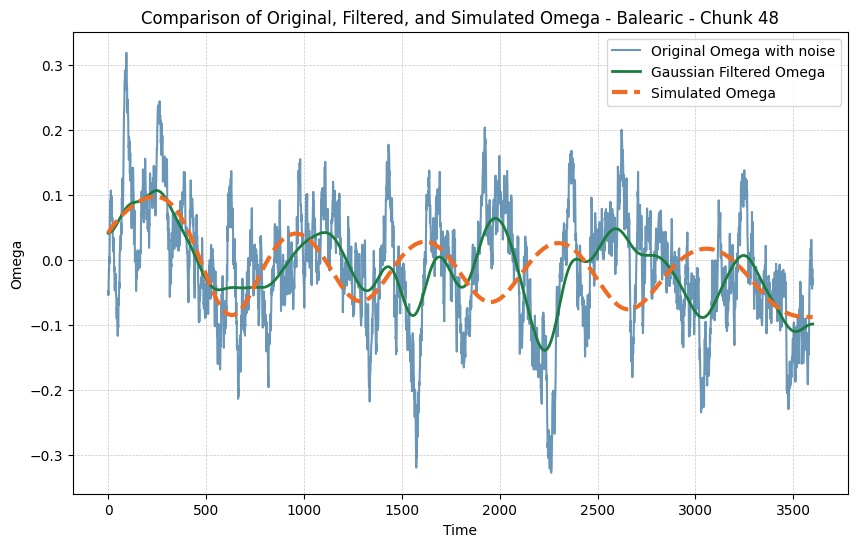

In [81]:
n=47
# Assume that 'omega_filtered' is the variable you want to integrate
initial_conditions = [integrate_data(balearic_data[n]['omega_filtered'].values)[0], 
                      balearic_data[n]['omega_filtered'].iloc[0],0]

# Define time points for simulation
total_time = len(balearic_data[1]['omega_filtered'])
time_points = np.arange(0, total_time, 1)

# Assuming omega_original and omega_filtered are available
omega_original = balearic_data[n]['omega'].values  # Replace 'omega' with the actual column name
omega_filtered = balearic_data[n]['omega_filtered'].values

# Simulate and plot results for a specific chunk (e.g., chunk 2)
simulate_sindy_model(balearic_models[n], initial_conditions, time_points, f'Balearic - Chunk {n+1}', omega_original, omega_filtered)
